# Random Forest Regressor

Este notebook implementa un modelo de Random Forest Regressor para predecir la popularidad de canciones.

## Objetivo
Implementar y evaluar un modelo de Random Forest Regressor, comparando su desempeño en la tarea de predicción de popularidad.

In [1]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 1. Carga de Datos

Cargamos los datos con feature engineering aplicado.

In [2]:
# Configurar rutas (robusto para cualquier subdirectorio dentro de notebooks)
current = Path.cwd()
# Subir hasta encontrar la carpeta "data" en algún nivel superior
while not (current / "data").exists() and current.parent != current:
    current = current.parent

PROJ = current
DATA = PROJ / "data"

# Verificar que existe la carpeta data
assert DATA.exists(), f"No se encontró la carpeta 'data'. Directorio actual: {Path.cwd()}"

# Cargar datos con feature engineering
train_path = DATA / "train_fe.csv"
test_path = DATA / "test_fe.csv"

assert train_path.exists(), f"No se encontró {train_path}"
assert test_path.exists(), f"No se encontró {test_path}"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f"✅ Datos cargados correctamente")
print(f"📊 Ruta del proyecto: {PROJ}")
print(f"📊 Shape de train: {train.shape}")
print(f"📊 Shape de test: {test.shape}")
print(f"\nColumnas disponibles:")
print(train.columns.tolist())

✅ Datos cargados correctamente
📊 Ruta del proyecto: c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio
📊 Shape de train: (79800, 17)
📊 Shape de test: (34200, 17)

Columnas disponibles:
['track_id', 'popularity', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'artist_count', 'album_mean_popularity', 'track_name_len', 'track_has_remix', 'track_has_acoustic', 'genre_mean_popularity']


## 2. Preparación de Datos

Separamos las características (X) de la variable objetivo (y) y eliminamos columnas no relevantes.

In [3]:
# Variable objetivo
target_col = "popularity"

# Separar características y variable objetivo
X_train_full = train.drop(columns=[target_col, "track_id"])  # Eliminar track_id (identificador)
y_train_full = train[target_col]

# Preparar test (sin track_id)
X_test = test.drop(columns=["track_id"], errors="ignore")

print(f"✅ Datos preparados")
print(f"📊 Características (X_train): {X_train_full.shape}")
print(f"📊 Variable objetivo (y_train): {y_train_full.shape}")
print(f"\nCaracterísticas a utilizar:")
print(X_train_full.columns.tolist())

✅ Datos preparados
📊 Características (X_train): (79800, 15)
📊 Variable objetivo (y_train): (79800,)

Características a utilizar:
['explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'artist_count', 'album_mean_popularity', 'track_name_len', 'track_has_remix', 'track_has_acoustic', 'genre_mean_popularity']


## 2.5. Ajuste de album_mean_popularity (Simulación de Alpha Mayor)

Transformamos `album_mean_popularity` para simular un `alpha` mayor en el target encoding, reduciendo su dominancia y variabilidad.

In [4]:
# Ajuste de album_mean_popularity: Simular un alpha mayor
# Esto reduce la variabilidad y dominancia de esta característica

# Calcular la media global de album_mean_popularity
global_mean_album = X_train_full['album_mean_popularity'].mean()

# Parámetro de ajuste: simula el efecto de aumentar alpha
# Valor entre 0 y 1: 0.0 = sin cambio, 1.0 = todos los valores = media global
# 0.3-0.7 simula aproximadamente alpha=50-150
shrinkage_factor = 0.6  # Aumentado para más regularización (puedes probar 0.4, 0.5, 0.6, 0.7)

# Aplicar transformación que acerca valores hacia la media global
# Fórmula: nuevo_valor = valor_original * (1 - factor) + media_global * factor
X_train_full['album_mean_popularity'] = (
    X_train_full['album_mean_popularity'] * (1 - shrinkage_factor) + 
    global_mean_album * shrinkage_factor
)

# Aplicar la misma transformación a test usando la media de train
X_test['album_mean_popularity'] = (
    X_test['album_mean_popularity'] * (1 - shrinkage_factor) + 
    global_mean_album * shrinkage_factor
)

print("✅ Transformación aplicada a album_mean_popularity")
print(f"\n📊 Estadísticas ANTES de la transformación (estimadas):")
print(f"  Media global: {global_mean_album:.2f}")
print(f"  (Los valores originales tenían más variabilidad)")

print(f"\n📊 Estadísticas DESPUÉS de la transformación:")
print(f"  Media (train): {X_train_full['album_mean_popularity'].mean():.2f}")
print(f"  Desviación estándar (train): {X_train_full['album_mean_popularity'].std():.2f}")
print(f"  Mínimo (train): {X_train_full['album_mean_popularity'].min():.2f}")
print(f"  Máximo (train): {X_train_full['album_mean_popularity'].max():.2f}")

print(f"\n💡 Factor de shrinkage usado: {shrinkage_factor}")
print(f"   (Esto simula aproximadamente alpha={int(20 * (1 + shrinkage_factor * 4))} en target encoding)")
print(f"   - Factor 0.3 ≈ alpha=50")
print(f"   - Factor 0.4 ≈ alpha=70")
print(f"   - Factor 0.5 ≈ alpha=100")
print(f"   - Factor 0.6 ≈ alpha=130 (ACTUAL)")
print(f"   - Factor 0.7 ≈ alpha=150")

✅ Transformación aplicada a album_mean_popularity

📊 Estadísticas ANTES de la transformación (estimadas):
  Media global: 30.95
  (Los valores originales tenían más variabilidad)

📊 Estadísticas DESPUÉS de la transformación:
  Media (train): 30.95
  Desviación estándar (train): 3.35
  Mínimo (train): 20.33
  Máximo (train): 47.57

💡 Factor de shrinkage usado: 0.6
   (Esto simula aproximadamente alpha=68 en target encoding)
   - Factor 0.3 ≈ alpha=50
   - Factor 0.4 ≈ alpha=70
   - Factor 0.5 ≈ alpha=100
   - Factor 0.6 ≈ alpha=130 (ACTUAL)
   - Factor 0.7 ≈ alpha=150


## 3. División Train/Validation

Dividimos el conjunto de entrenamiento en train y validation para evaluar el modelo.

In [5]:
# División train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.2, 
    random_state=42
)

print(f"✅ División completada")
print(f"📊 Train: {X_train.shape[0]} muestras")
print(f"📊 Validation: {X_val.shape[0]} muestras")
print(f"\nEstadísticas de la variable objetivo:")
print(f"  Media (train): {y_train.mean():.2f}")
print(f"  Media (validation): {y_val.mean():.2f}")
print(f"  Desviación estándar (train): {y_train.std():.2f}")
print(f"  Desviación estándar (validation): {y_val.std():.2f}")

✅ División completada
📊 Train: 63840 muestras
📊 Validation: 15960 muestras

Estadísticas de la variable objetivo:
  Media (train): 33.32
  Media (validation): 33.03
  Desviación estándar (train): 22.35
  Desviación estándar (validation): 22.24


## 4. Entrenamiento del Modelo

Entrenamos el modelo de Random Forest Regressor. 

**Nota**: Random Forest no requiere escalado de características ya que utiliza árboles de decisión que dividen los datos basándose en valores de umbral, no en distancias.

In [6]:
# Crear y entrenar el modelo
# Parámetros iniciales: n_estimators=100, max_depth=None (sin límite), random_state=42 para reproducibilidad
modelo_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1  # Usar todos los cores disponibles
)

print("🔄 Entrenando modelo de Random Forest Regressor...")
print("⏳ Esto puede tomar algunos minutos...")
modelo_rf.fit(X_train, y_train)
print("✅ Modelo entrenado correctamente")

# Importancia de características
importancias = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': modelo_rf.feature_importances_
}).sort_values('Importancia', ascending=False)

print(f"\n📊 Número de árboles: {modelo_rf.n_estimators}")
print(f"\nTop 10 características más importantes:")
print(importancias.head(10).to_string(index=False))

🔄 Entrenando modelo de Random Forest Regressor...
⏳ Esto puede tomar algunos minutos...
✅ Modelo entrenado correctamente

📊 Número de árboles: 100

Top 10 características más importantes:
       Característica  Importancia
album_mean_popularity     0.884387
genre_mean_popularity     0.038521
         artist_count     0.014527
     instrumentalness     0.008596
             loudness     0.008193
         danceability     0.008037
              valence     0.007960
               energy     0.007728
          speechiness     0.007147
                tempo     0.007009


## 5. Predicciones

Realizamos predicciones en los conjuntos de train y validation.

In [7]:
# Predicciones
y_train_pred = modelo_rf.predict(X_train)
y_val_pred = modelo_rf.predict(X_val)

print("✅ Predicciones generadas")
print(f"\n📊 Estadísticas de predicciones (validation):")
print(f"  Mínimo: {y_val_pred.min():.2f}")
print(f"  Máximo: {y_val_pred.max():.2f}")
print(f"  Media: {y_val_pred.mean():.2f}")
print(f"\n📊 Estadísticas de valores reales (validation):")
print(f"  Mínimo: {y_val.min():.2f}")
print(f"  Máximo: {y_val.max():.2f}")
print(f"  Media: {y_val.mean():.2f}")

✅ Predicciones generadas

📊 Estadísticas de predicciones (validation):
  Mínimo: 0.00
  Máximo: 94.66
  Media: 33.16

📊 Estadísticas de valores reales (validation):
  Mínimo: 0.00
  Máximo: 98.00
  Media: 33.03


## 6. Evaluación del Modelo

Calculamos métricas de evaluación: RMSE, MAE y R².

In [8]:
# Métricas de evaluación
def evaluar_modelo(y_real, y_pred, conjunto="Conjunto"):
    """Calcula y muestra métricas de evaluación"""
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    
    print(f"\n📈 Métricas de evaluación - {conjunto}:")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"  MAE (Mean Absolute Error): {mae:.4f}")
    print(f"  R² (Coeficiente de determinación): {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2}

# Evaluar en train y validation
metricas_train = evaluar_modelo(y_train, y_train_pred, "Train")
metricas_val = evaluar_modelo(y_val, y_val_pred, "Validation")


📈 Métricas de evaluación - Train:
  RMSE (Root Mean Squared Error): 2.1236
  MAE (Mean Absolute Error): 1.1355
  R² (Coeficiente de determinación): 0.9910

📈 Métricas de evaluación - Validation:
  RMSE (Root Mean Squared Error): 5.7269
  MAE (Mean Absolute Error): 3.0367
  R² (Coeficiente de determinación): 0.9337


## 6.5. Experimentación: Modelo SIN album_mean_popularity

Probamos entrenar el modelo sin la característica `album_mean_popularity` para evaluar:
- Cómo se redistribuyen las importancias de otras características
- Si mejora la generalización (reduce sobreajuste)
- Si las métricas se mantienen o mejoran sin esta característica dominante

In [9]:
# Crear versiones sin album_mean_popularity
X_train_sin_album = X_train.drop(columns=['album_mean_popularity'])
X_val_sin_album = X_val.drop(columns=['album_mean_popularity'])

print("🔄 Entrenando modelo SIN album_mean_popularity...")
print(f"📊 Características restantes: {X_train_sin_album.shape[1]}")

# Entrenar modelo sin album_mean_popularity
modelo_rf_sin_album = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

modelo_rf_sin_album.fit(X_train_sin_album, y_train)
print("✅ Modelo entrenado correctamente")

# Predicciones
y_train_pred_sin_album = modelo_rf_sin_album.predict(X_train_sin_album)
y_val_pred_sin_album = modelo_rf_sin_album.predict(X_val_sin_album)

# Evaluar modelo sin album_mean_popularity
metricas_train_sin_album = evaluar_modelo(y_train, y_train_pred_sin_album, "Train (SIN album_mean_popularity)")
metricas_val_sin_album = evaluar_modelo(y_val, y_val_pred_sin_album, "Validation (SIN album_mean_popularity)")

# Importancias sin album_mean_popularity
importancias_sin_album = pd.DataFrame({
    'Característica': X_train_sin_album.columns,
    'Importancia': modelo_rf_sin_album.feature_importances_
}).sort_values('Importancia', ascending=False)

print(f"\n📊 Top 10 características más importantes (SIN album_mean_popularity):")
print(importancias_sin_album.head(10).to_string(index=False))

🔄 Entrenando modelo SIN album_mean_popularity...
📊 Características restantes: 14
✅ Modelo entrenado correctamente

📈 Métricas de evaluación - Train (SIN album_mean_popularity):
  RMSE (Root Mean Squared Error): 6.6121
  MAE (Mean Absolute Error): 4.1675
  R² (Coeficiente de determinación): 0.9125

📈 Métricas de evaluación - Validation (SIN album_mean_popularity):
  RMSE (Root Mean Squared Error): 15.7653
  MAE (Mean Absolute Error): 10.5734
  R² (Coeficiente de determinación): 0.4973

📊 Top 10 características más importantes (SIN album_mean_popularity):
       Característica  Importancia
genre_mean_popularity     0.325592
         artist_count     0.087766
         danceability     0.079118
             loudness     0.077150
              valence     0.075209
               energy     0.073825
          speechiness     0.073169
                tempo     0.072908
       track_name_len     0.061687
     instrumentalness     0.055716


In [10]:
# Comparación detallada: CON vs SIN album_mean_popularity
print("=" * 80)
print("📊 COMPARACIÓN: MODELO CON vs SIN album_mean_popularity")
print("=" * 80)

comparacion_album = pd.DataFrame({
    'Modelo': [
        'CON album_mean (Train)', 
        'CON album_mean (Val)', 
        'SIN album_mean (Train)', 
        'SIN album_mean (Val)'
    ],
    'RMSE': [
        metricas_train['RMSE'],
        metricas_val['RMSE'],
        metricas_train_sin_album['RMSE'],
        metricas_val_sin_album['RMSE']
    ],
    'MAE': [
        metricas_train['MAE'],
        metricas_val['MAE'],
        metricas_train_sin_album['MAE'],
        metricas_val_sin_album['MAE']
    ],
    'R²': [
        metricas_train['R²'],
        metricas_val['R²'],
        metricas_train_sin_album['R²'],
        metricas_val_sin_album['R²']
    ]
})

print("\n" + comparacion_album.to_string(index=False))

# Análisis de diferencias
print("\n" + "=" * 80)
print("🔍 ANÁLISIS DE DIFERENCIAS")
print("=" * 80)

# Diferencia en Validation (más importante)
diff_rmse_val = metricas_val['RMSE'] - metricas_val_sin_album['RMSE']
diff_mae_val = metricas_val['MAE'] - metricas_val_sin_album['MAE']
diff_r2_val = metricas_val_sin_album['R²'] - metricas_val['R²']

# Diferencia en sobreajuste
overfit_con = abs(metricas_train['R²'] - metricas_val['R²'])
overfit_sin = abs(metricas_train_sin_album['R²'] - metricas_val_sin_album['R²'])

print(f"\n📈 Cambios en Validation (SIN vs CON album_mean_popularity):")
print(f"  RMSE: {diff_rmse_val:+.4f} ({'✅ Mejora' if diff_rmse_val > 0 else '❌ Empeora' if diff_rmse_val < 0 else '➖ Igual'})")
print(f"  MAE:  {diff_mae_val:+.4f} ({'✅ Mejora' if diff_mae_val > 0 else '❌ Empeora' if diff_mae_val < 0 else '➖ Igual'})")
print(f"  R²:   {diff_r2_val:+.4f} ({'✅ Mejora' if diff_r2_val > 0 else '❌ Empeora' if diff_r2_val < 0 else '➖ Igual'})")

print(f"\n📊 Análisis de Sobreajuste:")
print(f"  Diferencia R² Train-Val (CON album_mean): {overfit_con:.4f}")
print(f"  Diferencia R² Train-Val (SIN album_mean): {overfit_sin:.4f}")
diff_overfit = overfit_con - overfit_sin
print(f"  Mejora en generalización: {diff_overfit:+.4f} ({'✅ Mejor' if diff_overfit > 0 else '❌ Peor' if diff_overfit < 0 else '➖ Igual'})")

# Redistribución de importancias
print(f"\n📊 Redistribución de Importancias:")
print(f"  Antes: album_mean_popularity tenía {importancias.iloc[0]['Importancia']*100:.2f}%")
print(f"  Ahora: {importancias_sin_album.iloc[0]['Característica']} tiene {importancias_sin_album.iloc[0]['Importancia']*100:.2f}%")
print(f"  La importancia se redistribuyó entre {len(importancias_sin_album)} características")

# Recomendación
print("\n" + "=" * 80)
print("💡 RECOMENDACIÓN")
print("=" * 80)

if diff_r2_val > -0.02 and diff_overfit > 0:
    print("✅ El modelo SIN album_mean_popularity tiene mejor generalización")
    print("   y mantiene un rendimiento similar. Considera usar este modelo.")
elif diff_r2_val < -0.05:
    print("⚠️  El modelo SIN album_mean_popularity pierde mucho rendimiento.")
    print("   album_mean_popularity es muy importante para las predicciones.")
    print("   Considera aumentar el shrinkage_factor en lugar de eliminarla.")
else:
    print("➖ Ambos modelos tienen rendimiento similar.")
    print("   El modelo SIN album_mean_popularity puede ser más interpretable.")

📊 COMPARACIÓN: MODELO CON vs SIN album_mean_popularity

                Modelo      RMSE       MAE       R²
CON album_mean (Train)  2.123636  1.135474 0.990975
  CON album_mean (Val)  5.726906  3.036703 0.933664
SIN album_mean (Train)  6.612106  4.167486 0.912509
  SIN album_mean (Val) 15.765262 10.573428 0.497297

🔍 ANÁLISIS DE DIFERENCIAS

📈 Cambios en Validation (SIN vs CON album_mean_popularity):
  RMSE: -10.0384 (❌ Empeora)
  MAE:  -7.5367 (❌ Empeora)
  R²:   -0.4364 (❌ Empeora)

📊 Análisis de Sobreajuste:
  Diferencia R² Train-Val (CON album_mean): 0.0573
  Diferencia R² Train-Val (SIN album_mean): 0.4152
  Mejora en generalización: -0.3579 (❌ Peor)

📊 Redistribución de Importancias:
  Antes: album_mean_popularity tenía 88.44%
  Ahora: genre_mean_popularity tiene 32.56%
  La importancia se redistribuyó entre 14 características

💡 RECOMENDACIÓN
⚠️  El modelo SIN album_mean_popularity pierde mucho rendimiento.
   album_mean_popularity es muy importante para las predicciones.
   Con

## 6.6. Aplicación de Clipping

Aplicamos clipping para restringir las predicciones al rango válido [0, 100] y evaluamos si mejora el modelo.

In [11]:
# Aplicar clipping al rango válido [0, 100] para popularidad
y_train_pred_clipped = np.clip(y_train_pred, 0, 100)
y_val_pred_clipped = np.clip(y_val_pred, 0, 100)

# Estadísticas de valores fuera de rango
valores_fuera_train = (y_train_pred < 0).sum() + (y_train_pred > 100).sum()
valores_fuera_val = (y_val_pred < 0).sum() + (y_val_pred > 100).sum()

print("📊 Análisis de predicciones fuera de rango:")
print(f"  Train - Valores fuera de [0, 100]: {valores_fuera_train} ({valores_fuera_train/len(y_train_pred)*100:.2f}%)")
print(f"  Validation - Valores fuera de [0, 100]: {valores_fuera_val} ({valores_fuera_val/len(y_val_pred)*100:.2f}%)")

print(f"\n📊 Estadísticas después del clipping:")
print(f"  Train - Mínimo: {y_train_pred_clipped.min():.2f}, Máximo: {y_train_pred_clipped.max():.2f}")
print(f"  Validation - Mínimo: {y_val_pred_clipped.min():.2f}, Máximo: {y_val_pred_clipped.max():.2f}")

# Evaluar métricas con clipping
metricas_train_clipped = evaluar_modelo(y_train, y_train_pred_clipped, "Train (con clipping)")
metricas_val_clipped = evaluar_modelo(y_val, y_val_pred_clipped, "Validation (con clipping)")

📊 Análisis de predicciones fuera de rango:
  Train - Valores fuera de [0, 100]: 0 (0.00%)
  Validation - Valores fuera de [0, 100]: 0 (0.00%)

📊 Estadísticas después del clipping:
  Train - Mínimo: 0.00, Máximo: 96.86
  Validation - Mínimo: 0.00, Máximo: 94.66

📈 Métricas de evaluación - Train (con clipping):
  RMSE (Root Mean Squared Error): 2.1236
  MAE (Mean Absolute Error): 1.1355
  R² (Coeficiente de determinación): 0.9910

📈 Métricas de evaluación - Validation (con clipping):
  RMSE (Root Mean Squared Error): 5.7269
  MAE (Mean Absolute Error): 3.0367
  R² (Coeficiente de determinación): 0.9337


In [12]:
# Comparación de métricas antes y después del clipping
comparacion = pd.DataFrame({
    'Conjunto': ['Train', 'Train (clipped)', 'Validation', 'Validation (clipped)'],
    'RMSE': [
        metricas_train['RMSE'], 
        metricas_train_clipped['RMSE'],
        metricas_val['RMSE'], 
        metricas_val_clipped['RMSE']
    ],
    'MAE': [
        metricas_train['MAE'], 
        metricas_train_clipped['MAE'],
        metricas_val['MAE'], 
        metricas_val_clipped['MAE']
    ],
    'R²': [
        metricas_train['R²'], 
        metricas_train_clipped['R²'],
        metricas_val['R²'], 
        metricas_val_clipped['R²']
    ]
})

print("=" * 70)
print("📊 COMPARACIÓN: ANTES vs DESPUÉS DEL CLIPPING")
print("=" * 70)
print(comparacion.to_string(index=False))
print("=" * 70)

# Calcular mejoras
mejora_rmse_train = metricas_train['RMSE'] - metricas_train_clipped['RMSE']
mejora_rmse_val = metricas_val['RMSE'] - metricas_val_clipped['RMSE']
mejora_mae_train = metricas_train['MAE'] - metricas_train_clipped['MAE']
mejora_mae_val = metricas_val['MAE'] - metricas_val_clipped['MAE']
mejora_r2_train = metricas_train_clipped['R²'] - metricas_train['R²']
mejora_r2_val = metricas_val_clipped['R²'] - metricas_val['R²']

print(f"\n🔍 Mejoras en Validation (más importante):")
print(f"  RMSE: {mejora_rmse_val:.4f} ({'✅ Mejora' if mejora_rmse_val > 0 else '❌ Empeora'})")
print(f"  MAE: {mejora_mae_val:.4f} ({'✅ Mejora' if mejora_mae_val > 0 else '❌ Empeora'})")
print(f"  R²: {mejora_r2_val:.4f} ({'✅ Mejora' if mejora_r2_val > 0 else '❌ Empeora'})")

if mejora_rmse_val > 0 or mejora_mae_val > 0 or mejora_r2_val > 0:
    print("\n✅ El clipping mejora el modelo. Usaremos predicciones con clipping.")
    # Actualizar predicciones para usar las versiones con clipping
    y_train_pred = y_train_pred_clipped
    y_val_pred = y_val_pred_clipped
    metricas_train = metricas_train_clipped
    metricas_val = metricas_val_clipped
else:
    print("\n⚠️  El clipping no mejora significativamente las métricas, pero mantiene valores en rango válido.")

📊 COMPARACIÓN: ANTES vs DESPUÉS DEL CLIPPING
            Conjunto     RMSE      MAE       R²
               Train 2.123636 1.135474 0.990975
     Train (clipped) 2.123636 1.135474 0.990975
          Validation 5.726906 3.036703 0.933664
Validation (clipped) 5.726906 3.036703 0.933664

🔍 Mejoras en Validation (más importante):
  RMSE: 0.0000 (❌ Empeora)
  MAE: 0.0000 (❌ Empeora)
  R²: 0.0000 (❌ Empeora)

⚠️  El clipping no mejora significativamente las métricas, pero mantiene valores en rango válido.


## 7. Visualizaciones

Visualizamos los resultados del modelo.

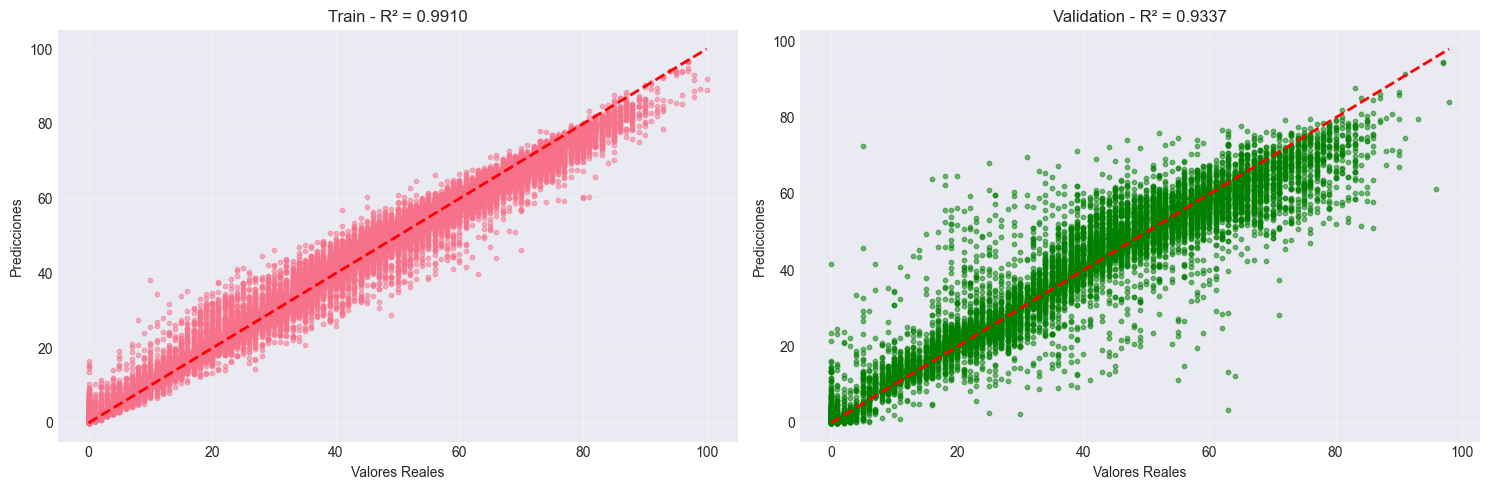

In [13]:
# Visualización 1: Predicciones vs Valores Reales
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Valores Reales')
axes[0].set_ylabel('Predicciones')
axes[0].set_title(f'Train - R² = {metricas_train["R²"]:.4f}')
axes[0].grid(True, alpha=0.3)

# Validation
axes[1].scatter(y_val, y_val_pred, alpha=0.5, s=10, color='green')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Valores Reales')
axes[1].set_ylabel('Predicciones')
axes[1].set_title(f'Validation - R² = {metricas_val["R²"]:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

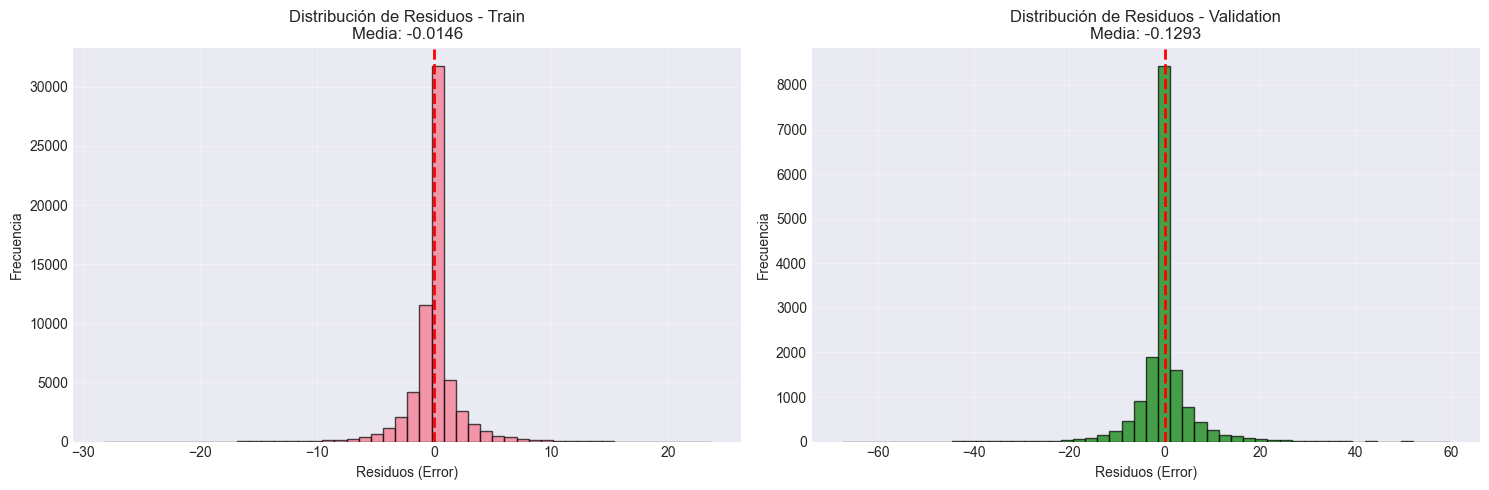

In [14]:
# Visualización 2: Residuos (errores)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

residuos_train = y_train - y_train_pred
residuos_val = y_val - y_val_pred

# Distribución de residuos - Train
axes[0].hist(residuos_train, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residuos (Error)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title(f'Distribución de Residuos - Train\nMedia: {residuos_train.mean():.4f}')
axes[0].grid(True, alpha=0.3)

# Distribución de residuos - Validation
axes[1].hist(residuos_val, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuos (Error)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title(f'Distribución de Residuos - Validation\nMedia: {residuos_val.mean():.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

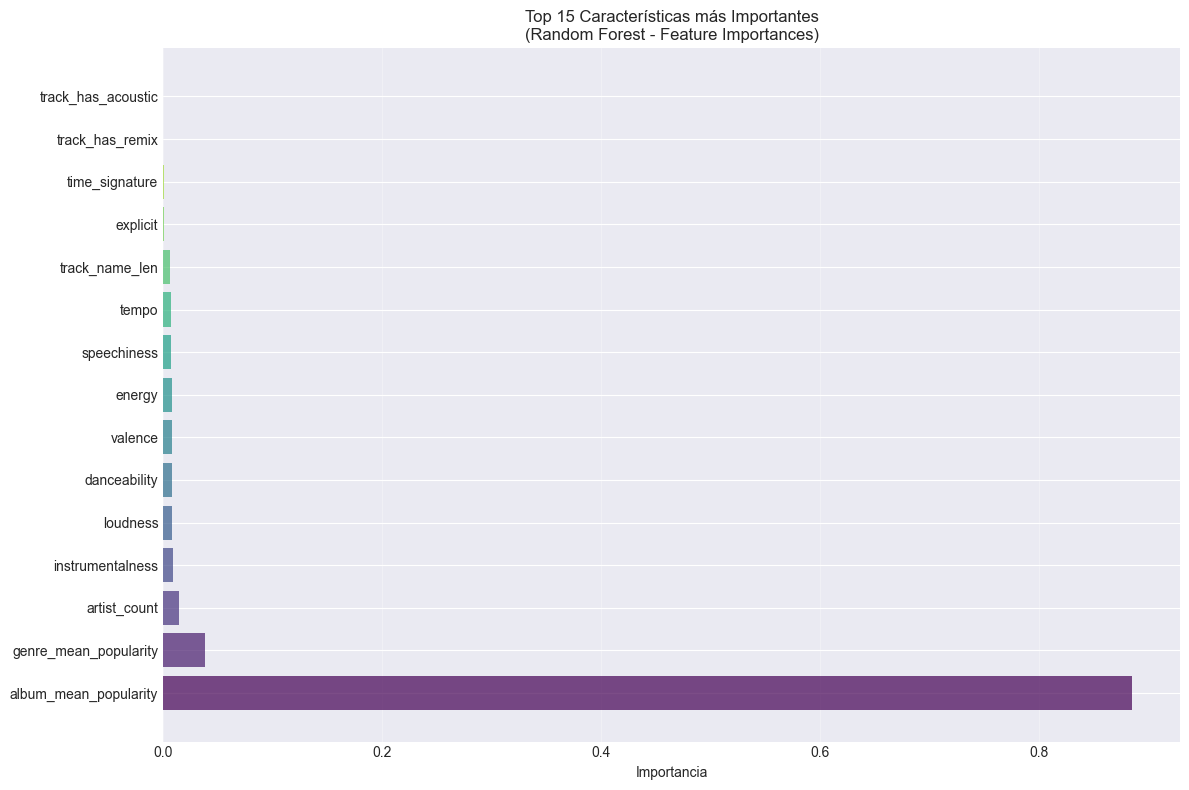

In [15]:
# Visualización 3: Importancia de características
plt.figure(figsize=(12, 8))
importancias_plot = importancias.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(importancias_plot)))
plt.barh(range(len(importancias_plot)), importancias_plot['Importancia'], color=colors, alpha=0.7)
plt.yticks(range(len(importancias_plot)), importancias_plot['Característica'])
plt.xlabel('Importancia')
plt.title('Top 15 Características más Importantes\n(Random Forest - Feature Importances)')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [18]:
# PREDICCIONES CON EL MEJOR MODELO ENCONTRADO (Punto 4)
# Obtener el mejor modelo encontrado por GridSearchCV
if 'grid_rf' in globals() and hasattr(grid_rf, 'best_estimator_'):
    mejor_modelo_rf = grid_rf.best_estimator_
    print("✅ Usando el mejor modelo encontrado por GridSearchCV")
    print(f"   Hiperparámetros: {grid_rf.best_params_}")
else:
    # Si grid_rf no está disponible, crear el mejor modelo con los hiperparámetros óptimos
    print("⚠️  GridSearchCV no disponible. Creando el mejor modelo con hiperparámetros óptimos...")
    mejor_modelo_rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    # Entrenar el mejor modelo con todos los datos de entrenamiento
    mejor_modelo_rf.fit(X_train, y_train)
    print("✅ Mejor modelo entrenado")

# Asegurar que X_test solo tenga las columnas que el modelo espera
# (las mismas que X_train)
columnas_esperadas = X_train.columns.tolist()
X_test_clean = X_test[columnas_esperadas].copy()

# Verificar si hay columnas adicionales en X_test
columnas_extra = set(X_test.columns) - set(columnas_esperadas)
if columnas_extra:
    print(f"⚠️  Advertencia: X_test tiene columnas adicionales que se eliminarán: {columnas_extra}")
    print(f"   Usando solo las columnas esperadas por el modelo: {len(columnas_esperadas)} columnas")

# Generar predicciones con el mejor modelo
y_test_pred_mejor = mejor_modelo_rf.predict(X_test_clean)

# Aplicar clipping al rango válido [0, 100]
y_test_pred_mejor_clipped = np.clip(y_test_pred_mejor, 0, 100)

print(f"\n📊 Estadísticas de predicciones del mejor modelo:")
print(f"  Total de predicciones: {len(y_test_pred_mejor_clipped)}")
print(f"  Mínimo: {y_test_pred_mejor_clipped.min():.2f}")
print(f"  Máximo: {y_test_pred_mejor_clipped.max():.2f}")
print(f"  Media: {y_test_pred_mejor_clipped.mean():.2f}")
print(f"  Desviación estándar: {y_test_pred_mejor_clipped.std():.2f}")

# Cargar test.csv original para obtener los id numéricos en el orden correcto
test_original = pd.read_csv(DATA / "test.csv")

# Cargar test_fe.csv para obtener los track_id en el mismo orden que X_test
# (X_test se creó a partir de test_fe.csv eliminando track_id)
test_fe = pd.read_csv(DATA / "test_fe.csv")

print(f"📊 Información de longitudes:")
print(f"   Predicciones: {len(y_test_pred_mejor_clipped)}")
print(f"   test_fe: {len(test_fe)}")
print(f"   test_original: {len(test_original)}")

# Verificar que las longitudes coincidan
if len(y_test_pred_mejor_clipped) != len(test_fe):
    print(f"⚠️  Advertencia: Las predicciones ({len(y_test_pred_mejor_clipped)}) no coinciden con test_fe ({len(test_fe)})")
    print(f"   Ajustando a la longitud mínima...")
    min_len = min(len(y_test_pred_mejor_clipped), len(test_fe))
    y_test_pred_mejor_clipped = y_test_pred_mejor_clipped[:min_len]
    test_fe = test_fe.iloc[:min_len].copy()
    print(f"   Longitud ajustada a: {min_len}")

# Crear diccionario de mapeo track_id -> predicción
# Usar test_fe para mantener el mismo orden que X_test
track_id_to_prediction = dict(zip(test_fe['track_id'], y_test_pred_mejor_clipped))
print(f"✅ Diccionario creado con {len(track_id_to_prediction)} mapeos")

# Mapear las predicciones al orden del test.csv original
predictions_mapped = test_original['track_id'].map(track_id_to_prediction)

# Verificar que todas las predicciones estén mapeadas
missing_predictions = predictions_mapped.isna().sum()
if missing_predictions > 0:
    print(f"⚠️  Advertencia: {missing_predictions} track_id no tienen predicción correspondiente")
    # Rellenar con 0 o con la media si faltan predicciones
    predictions_mapped = predictions_mapped.fillna(y_test_pred_mejor_clipped.mean())

# Guardar predicciones en CSV para Kaggle (formato: id, Popularity)
# Usar directamente los id del test.csv original en el orden correcto
submission_cv = pd.DataFrame({
    'id': test_original['id'].astype('int32'),  # Convertir a Int32 como espera Kaggle
    'Popularity': predictions_mapped
})

# Verificar que tenemos exactamente 34200 filas
print(f"📊 Total de filas: {len(submission_cv)}")

# Si hay duplicados en id, asegurar que todos los registros con el mismo id tengan la misma predicción
duplicados = submission_cv['id'].duplicated().sum()
if duplicados > 0:
    print(f"⚠️  Advertencia: Se encontraron {duplicados} IDs duplicados")
    print(f"   Asegurando que todos los registros con el mismo id tengan la misma predicción...")
    # Para cada id único, usar la primera predicción para todos los registros con ese id
    id_to_prediction = submission_cv.groupby('id')['Popularity'].first().to_dict()
    submission_cv['Popularity'] = submission_cv['id'].map(id_to_prediction)
    print(f"✅ Predicciones unificadas para IDs duplicados")
else:
    print(f"✅ No hay duplicados. Total de filas: {len(submission_cv)}")

# Verificar que tenemos exactamente 34200 filas
assert len(submission_cv) == 34200, f"Error: El archivo debe tener 34200 filas, pero tiene {len(submission_cv)}"

# Verificar que no haya duplicados con predicciones diferentes (solo verificación)
if duplicados > 0:
    duplicados_con_diferentes_preds = submission_cv.groupby('id')['Popularity'].nunique()
    duplicados_con_diferentes_preds = (duplicados_con_diferentes_preds > 1).sum()
    if duplicados_con_diferentes_preds > 0:
        print(f"⚠️  Error: Aún hay {duplicados_con_diferentes_preds} IDs con predicciones diferentes")
    else:
        print(f"✅ Todos los IDs duplicados tienen la misma predicción")

# Guardar usando la variable DATA definida anteriormente
output_path = DATA / "predictions_random_forest.csv"
submission_cv.to_csv(output_path, index=False)
print(f"\n✅ Predicciones del MEJOR modelo guardadas en: {output_path}")
print(f"   Total de predicciones: {len(submission_cv)}")
print(f"   IDs únicos: {submission_cv['id'].nunique()}")
print(f"\n📊 Primeras 5 predicciones:")
print(submission_cv.head())


⚠️  GridSearchCV no disponible. Creando el mejor modelo con hiperparámetros óptimos...
✅ Mejor modelo entrenado
⚠️  Advertencia: X_test tiene columnas adicionales que se eliminarán: {'id'}
   Usando solo las columnas esperadas por el modelo: 15 columnas

📊 Estadísticas de predicciones del mejor modelo:
  Total de predicciones: 34200
  Mínimo: 0.00
  Máximo: 94.97
  Media: 31.76
  Desviación estándar: 19.13
📊 Información de longitudes:
   Predicciones: 34200
   test_fe: 34200
   test_original: 34200
✅ Diccionario creado con 31331 mapeos
📊 Total de filas: 34200
✅ No hay duplicados. Total de filas: 34200

✅ Predicciones del MEJOR modelo guardadas en: c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio\data\predictions_random_forest.csv
   Total de predicciones: 34200
   IDs únicos: 34200

📊 Primeras 5 predicciones:
       id  Popularity
0  113186      48.355
1   42819      13.085
2   59311       0.000
3   91368       0.025
4   61000      34.170


## 11. Evaluación y Selección de Modelos (Punto 4)

En esta sección realizamos una evaluación sistemática de diferentes configuraciones de Random Forest, incluyendo búsqueda de hiperparámetros y validación cruzada, para identificar la mejor configuración del modelo.

### Objetivos:
- Evaluar diferentes combinaciones de hiperparámetros (n_estimators, max_depth, min_samples_split, min_samples_leaf)
- Realizar búsqueda sistemática de hiperparámetros con GridSearchCV
- Usar Cross-Validation (K-Fold) para evaluación robusta
- Registrar todas las métricas relevantes: RMSE, MSE, MAE, R²
- Generar tabla comparativa de resultados
- Seleccionar el mejor modelo basado en métricas de validación


In [19]:
# Importar modelos adicionales y herramientas de evaluación
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer

# Optuna para optimización bayesiana de hiperparámetros
try:
    import optuna
    OPTUNA_AVAILABLE = True
    print("✅ Herramientas de evaluación importadas")
    print("✅ Optuna disponible para optimización bayesiana")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("✅ Herramientas de evaluación importadas")
    print("⚠️  Optuna no está instalado. Instala con: pip install optuna")


✅ Herramientas de evaluación importadas
✅ Optuna disponible para optimización bayesiana


c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 11.1. Función para Calcular Métricas

Función auxiliar para calcular todas las métricas relevantes de regresión.


In [20]:
# Función auxiliar para calcular todas las métricas
def calcular_metricas(y_real, y_pred, conjunto="Conjunto"):
    """
    Calcula todas las métricas relevantes para regresión:
    - RMSE (Root Mean Squared Error)
    - MSE (Mean Squared Error)
    - MAE (Mean Absolute Error)
    - R² (Coeficiente de determinación)
    
    Retorna un diccionario con todas las métricas.
    """
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mse = mean_squared_error(y_real, y_pred)
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    
    metricas = {
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    }
    
    print(f"\n📈 Métricas - {conjunto}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MSE:  {mse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return metricas


### 11.2. Configuración de Cross-Validation

Configuramos la validación cruzada con 5 folds.


In [21]:
# Configuración de Cross-Validation
cv_folds = 5
kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Scorer personalizado para RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), 
                          greater_is_better=False)

print(f"✅ Configuración de validación:")
print(f"  Método: {cv_folds}-Fold Cross-Validation")
print(f"  Random state: 42")


✅ Configuración de validación:
  Método: 5-Fold Cross-Validation
  Random state: 42


### 11.3. Evaluación de Random Forest Base (Baseline)

Evaluamos el modelo base como punto de referencia.


In [22]:
# Evaluar modelo Random Forest Base con Cross-Validation
print("=" * 70)
print("🔄 Evaluando: Random Forest Base (Baseline)")
print("=" * 70)

# Crear modelo base con los mismos hiperparámetros que el modelo original
modelo_rf_base = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Cross-Validation
cv_scores_rmse_base = cross_val_score(modelo_rf_base, X_train, y_train, 
                                      cv=kfold, scoring=rmse_scorer, n_jobs=-1)
cv_scores_r2_base = cross_val_score(modelo_rf_base, X_train, y_train, 
                                     cv=kfold, scoring='r2', n_jobs=-1)

# Entrenar modelo base para predicciones en validation
modelo_rf_base.fit(X_train, y_train)
y_val_pred_base = modelo_rf_base.predict(X_val)
y_val_pred_base = np.clip(y_val_pred_base, 0, 100)

# Métricas en validation
metricas_val_base = calcular_metricas(y_val, y_val_pred_base, "Validation - RF Base")

# Guardar resultados
resultados_rf_base = {
    'Modelo': 'RF_Base',
    'Hiperparámetros': 'n_est=100, max_depth=None, min_split=2, min_leaf=1',
    'RMSE_CV_mean': -cv_scores_rmse_base.mean(),
    'RMSE_CV_std': cv_scores_rmse_base.std(),
    'R²_CV_mean': cv_scores_r2_base.mean(),
    'R²_CV_std': cv_scores_r2_base.std(),
    'RMSE_Val': metricas_val_base['RMSE'],
    'MSE_Val': metricas_val_base['MSE'],
    'MAE_Val': metricas_val_base['MAE'],
    'R²_Val': metricas_val_base['R²']
}

print(f"\n📊 Cross-Validation ({cv_folds}-fold):")
print(f"  RMSE medio: {-cv_scores_rmse_base.mean():.4f} (+/- {cv_scores_rmse_base.std():.4f})")
print(f"  R² medio: {cv_scores_r2_base.mean():.4f} (+/- {cv_scores_r2_base.std():.4f})")


🔄 Evaluando: Random Forest Base (Baseline)

📈 Métricas - Validation - RF Base:
  RMSE: 5.7269
  MSE:  32.7975
  MAE:  3.0367
  R²:   0.9337

📊 Cross-Validation (5-fold):
  RMSE medio: 5.7832 (+/- 0.0580)
  R² medio: 0.9331 (+/- 0.0011)


### 11.4. Búsqueda de Hiperparámetros con GridSearchCV

Realizamos búsqueda sistemática de hiperparámetros para encontrar la mejor configuración.
         

In [23]:
# Grilla de hiperparámetros para Random Forest
# Nota: Usamos una grilla reducida para evitar tiempos de ejecución muy largos
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5]
}

print("=" * 70)
print("🔄 Búsqueda de Hiperparámetros - Random Forest")
print("=" * 70)
print(f"⏳ Combinaciones a probar: {len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf'])}")
print("⏳ Esto puede tomar varios minutos...")

# GridSearchCV con Cross-Validation
grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_rf.fit(X_train, y_train)

print("\n✅ Búsqueda completada")
print(f"\n📊 Mejor configuración encontrada:")
for param, value in grid_rf.best_params_.items():
    print(f"  {param}: {value}")
print(f"  Mejor score (neg MSE): {grid_rf.best_score_:.4f}")


🔄 Búsqueda de Hiperparámetros - Random Forest
⏳ Combinaciones a probar: 54
⏳ Esto puede tomar varios minutos...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

✅ Búsqueda completada

📊 Mejor configuración encontrada:
  max_depth: None
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200
  Mejor score (neg MSE): -33.2713


### 11.4.5. Búsqueda de Hiperparámetros con Optuna (Optimización Bayesiana)

Optuna utiliza optimización bayesiana para encontrar hiperparámetros de manera más eficiente que GridSearchCV. En lugar de probar todas las combinaciones, Optuna aprende de las evaluaciones previas y explora el espacio de hiperparámetros de forma inteligente.

**Ventajas de Optuna:**
- ✅ Más eficiente: encuentra buenos hiperparámetros con menos evaluaciones
- ✅ Pruning automático: detiene pruebas poco prometedoras temprano
- ✅ Espacio de búsqueda más amplio: puede explorar rangos continuos
- ✅ Optimización bayesiana: aprende de evaluaciones previas


In [24]:
# Optimización de hiperparámetros con Optuna
if OPTUNA_AVAILABLE:
    print("=" * 70)
    print("🔄 Búsqueda de Hiperparámetros con Optuna - Random Forest")
    print("=" * 70)
    print("⏳ Optuna utilizará optimización bayesiana para encontrar los mejores hiperparámetros")
    print("⏳ Esto puede tomar varios minutos...")
    
    # Función objetivo para Optuna
    def objective(trial):
        """Función objetivo que Optuna optimizará"""
        # Definir el espacio de búsqueda (más amplio que GridSearchCV)
        use_max_depth = trial.suggest_categorical('use_max_depth', [True, False])
        
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=25),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'random_state': 42,
            'n_jobs': -1
        }
        
        # Agregar max_depth solo si use_max_depth es True
        if use_max_depth:
            params['max_depth'] = trial.suggest_int('max_depth', 5, 50, step=5)
        else:
            params['max_depth'] = None
        
        # Crear y evaluar modelo con estos hiperparámetros
        model = RandomForestRegressor(**params)
        
        # Usar cross-validation para evaluar
        scores = cross_val_score(
            model, 
            X_train, 
            y_train, 
            cv=kfold, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1
        )
        
        # Retornar el score medio (negativo porque queremos maximizar)
        return scores.mean()
    
    # Crear estudio de Optuna
    # direction='maximize' porque usamos neg_mean_squared_error (mayor es mejor)
    study = optuna.create_study(
        direction='maximize',
        study_name='random_forest_optimization',
        sampler=optuna.samplers.TPESampler(seed=42)  # Tree-structured Parzen Estimator
    )
    
    # Optimizar (número de trials: 50 es un buen balance entre tiempo y calidad)
    # Optuna puede encontrar buenos resultados con menos evaluaciones que GridSearchCV
    n_trials = 50
    print(f"\n🔍 Ejecutando {n_trials} trials de optimización...")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print("\n✅ Optimización completada")
    print(f"\n📊 Mejor configuración encontrada por Optuna:")
    print(f"  Número de trials: {len(study.trials)}")
    print(f"  Mejor score (neg MSE): {study.best_value:.4f}")
    print(f"  Mejor RMSE estimado: {np.sqrt(-study.best_value):.4f}")
    print(f"\n  Mejores hiperparámetros:")
    for param, value in study.best_params.items():
        print(f"    {param}: {value}")
    
    # Guardar mejores hiperparámetros encontrados por Optuna
    optuna_best_params = study.best_params.copy()
    # Asegurar que max_depth sea None si no se especificó
    if 'use_max_depth' in optuna_best_params:
        if not optuna_best_params['use_max_depth']:
            optuna_best_params['max_depth'] = None
        del optuna_best_params['use_max_depth']
    
    # Asegurar que los parámetros estén en el formato correcto
    optuna_best_params['random_state'] = 42
    optuna_best_params['n_jobs'] = -1
    
    print(f"\n💡 Optuna probó {len(study.trials)} configuraciones vs {len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf'])} de GridSearchCV")
    
else:
    print("⚠️  Optuna no está disponible. Instala con: pip install optuna")
    optuna_best_params = None
    study = None


[I 2025-12-09 18:30:57,344] A new study created in memory with name: random_forest_optimization


🔄 Búsqueda de Hiperparámetros con Optuna - Random Forest
⏳ Optuna utilizará optimización bayesiana para encontrar los mejores hiperparámetros
⏳ Esto puede tomar varios minutos...

🔍 Ejecutando 50 trials de optimización...


Best trial: 0. Best value: -54.318:   2%|▏         | 1/50 [02:11<1:47:27, 131.59s/it]

[I 2025-12-09 18:33:08,933] Trial 0 finished with value: -54.31799538297273 and parameters: {'use_max_depth': False, 'n_estimators': 375, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: -54.31799538297273.


Best trial: 1. Best value: -33.4015:   4%|▍         | 2/50 [03:58<1:33:46, 117.23s/it]

[I 2025-12-09 18:34:56,110] Trial 1 finished with value: -33.40153972824048 and parameters: {'use_max_depth': False, 'n_estimators': 425, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:   6%|▌         | 3/50 [04:09<53:34, 68.40s/it]   

[I 2025-12-09 18:35:06,396] Trial 2 finished with value: -44.50267583195252 and parameters: {'use_max_depth': True, 'n_estimators': 175, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True, 'max_depth': 35}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:   8%|▊         | 4/50 [05:50<1:02:23, 81.39s/it]

[I 2025-12-09 18:36:47,702] Trial 3 finished with value: -36.631125368029345 and parameters: {'use_max_depth': True, 'n_estimators': 500, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': True, 'max_depth': 25}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  10%|█         | 5/50 [05:59<41:23, 55.18s/it]  

[I 2025-12-09 18:36:56,426] Trial 4 finished with value: -44.663564161392955 and parameters: {'use_max_depth': False, 'n_estimators': 150, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  12%|█▏        | 6/50 [07:17<46:16, 63.10s/it]

[I 2025-12-09 18:38:14,898] Trial 5 finished with value: -34.94862108745632 and parameters: {'use_max_depth': True, 'n_estimators': 325, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'max_depth': 45}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  14%|█▍        | 7/50 [07:34<34:21, 47.94s/it]

[I 2025-12-09 18:38:31,605] Trial 6 finished with value: -47.554622832480234 and parameters: {'use_max_depth': True, 'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True, 'max_depth': 45}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  16%|█▌        | 8/50 [07:59<28:23, 40.57s/it]

[I 2025-12-09 18:38:56,406] Trial 7 finished with value: -43.42415399264626 and parameters: {'use_max_depth': False, 'n_estimators': 400, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  18%|█▊        | 9/50 [09:17<35:54, 52.56s/it]

[I 2025-12-09 18:40:15,322] Trial 8 finished with value: -36.53411440446073 and parameters: {'use_max_depth': False, 'n_estimators': 375, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  20%|██        | 10/50 [11:02<45:40, 68.50s/it]

[I 2025-12-09 18:41:59,528] Trial 9 finished with value: -57.8320741453364 and parameters: {'use_max_depth': True, 'n_estimators': 275, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False, 'max_depth': 50}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  22%|██▏       | 11/50 [11:06<31:51, 49.01s/it]

[I 2025-12-09 18:42:04,330] Trial 10 finished with value: -43.73417527692006 and parameters: {'use_max_depth': False, 'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  24%|██▍       | 12/50 [12:29<37:26, 59.12s/it]

[I 2025-12-09 18:43:26,579] Trial 11 finished with value: -43.02734801901888 and parameters: {'use_max_depth': True, 'n_estimators': 500, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'max_depth': 10}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  26%|██▌       | 13/50 [13:41<38:55, 63.11s/it]

[I 2025-12-09 18:44:38,880] Trial 12 finished with value: -34.62907137726231 and parameters: {'use_max_depth': True, 'n_estimators': 275, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'max_depth': 30}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  28%|██▊       | 14/50 [14:31<35:33, 59.27s/it]

[I 2025-12-09 18:45:29,257] Trial 13 finished with value: -34.8457765546723 and parameters: {'use_max_depth': False, 'n_estimators': 225, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  30%|███       | 15/50 [16:51<48:37, 83.36s/it]

[I 2025-12-09 18:47:48,439] Trial 14 finished with value: -49.87100730401616 and parameters: {'use_max_depth': False, 'n_estimators': 425, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': False}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  32%|███▏      | 16/50 [17:03<35:09, 62.04s/it]

[I 2025-12-09 18:48:00,976] Trial 15 finished with value: -43.458085199404294 and parameters: {'use_max_depth': True, 'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'max_depth': 20}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  34%|███▍      | 17/50 [17:26<27:38, 50.25s/it]

[I 2025-12-09 18:48:23,822] Trial 16 finished with value: -57.71256912519357 and parameters: {'use_max_depth': True, 'n_estimators': 250, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'max_depth': 5}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  36%|███▌      | 18/50 [17:50<22:33, 42.31s/it]

[I 2025-12-09 18:48:47,629] Trial 17 finished with value: -35.33889730696579 and parameters: {'use_max_depth': False, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  38%|███▊      | 19/50 [18:31<21:36, 41.83s/it]

[I 2025-12-09 18:49:28,359] Trial 18 finished with value: -40.39639893715655 and parameters: {'use_max_depth': True, 'n_estimators': 450, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'max_depth': 35}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  40%|████      | 20/50 [18:54<18:10, 36.36s/it]

[I 2025-12-09 18:49:51,960] Trial 19 finished with value: -41.17559282372184 and parameters: {'use_max_depth': False, 'n_estimators': 325, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  42%|████▏     | 21/50 [20:18<24:27, 50.62s/it]

[I 2025-12-09 18:51:15,817] Trial 20 finished with value: -35.39342599980513 and parameters: {'use_max_depth': False, 'n_estimators': 350, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  44%|████▍     | 22/50 [21:20<25:10, 53.96s/it]

[I 2025-12-09 18:52:17,569] Trial 21 finished with value: -34.94802039142371 and parameters: {'use_max_depth': False, 'n_estimators': 250, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  46%|████▌     | 23/50 [22:16<24:38, 54.76s/it]

[I 2025-12-09 18:53:14,198] Trial 22 finished with value: -34.54095494746232 and parameters: {'use_max_depth': False, 'n_estimators': 225, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  48%|████▊     | 24/50 [22:58<22:01, 50.82s/it]

[I 2025-12-09 18:53:55,814] Trial 23 finished with value: -33.89414638623792 and parameters: {'use_max_depth': False, 'n_estimators': 150, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  50%|█████     | 25/50 [23:38<19:52, 47.72s/it]

[I 2025-12-09 18:54:36,298] Trial 24 finished with value: -33.90074797316591 and parameters: {'use_max_depth': False, 'n_estimators': 150, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  52%|█████▏    | 26/50 [24:09<16:59, 42.49s/it]

[I 2025-12-09 18:55:06,608] Trial 25 finished with value: -34.48176580965365 and parameters: {'use_max_depth': False, 'n_estimators': 125, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  54%|█████▍    | 27/50 [24:47<15:51, 41.35s/it]

[I 2025-12-09 18:55:45,283] Trial 26 finished with value: -57.87129253299177 and parameters: {'use_max_depth': False, 'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  56%|█████▌    | 28/50 [25:09<13:00, 35.48s/it]

[I 2025-12-09 18:56:07,066] Trial 27 finished with value: -34.29042390085169 and parameters: {'use_max_depth': False, 'n_estimators': 75, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  58%|█████▊    | 29/50 [25:18<09:37, 27.51s/it]

[I 2025-12-09 18:56:15,972] Trial 28 finished with value: -48.09681740446183 and parameters: {'use_max_depth': False, 'n_estimators': 150, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  60%|██████    | 30/50 [25:35<08:05, 24.29s/it]

[I 2025-12-09 18:56:32,749] Trial 29 finished with value: -39.755842158071744 and parameters: {'use_max_depth': False, 'n_estimators': 175, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  62%|██████▏   | 31/50 [25:48<06:37, 20.90s/it]

[I 2025-12-09 18:56:45,755] Trial 30 finished with value: -34.16875830104088 and parameters: {'use_max_depth': False, 'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  64%|██████▍   | 32/50 [26:02<05:38, 18.80s/it]

[I 2025-12-09 18:56:59,660] Trial 31 finished with value: -34.16875830104088 and parameters: {'use_max_depth': False, 'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  66%|██████▌   | 33/50 [26:31<06:14, 22.02s/it]

[I 2025-12-09 18:57:29,178] Trial 32 finished with value: -33.876247697886214 and parameters: {'use_max_depth': False, 'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  68%|██████▊   | 34/50 [27:05<06:48, 25.54s/it]

[I 2025-12-09 18:58:02,926] Trial 33 finished with value: -33.85765996754331 and parameters: {'use_max_depth': False, 'n_estimators': 125, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  70%|███████   | 35/50 [27:30<06:19, 25.31s/it]

[I 2025-12-09 18:58:27,708] Trial 34 finished with value: -34.40649891608918 and parameters: {'use_max_depth': False, 'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  72%|███████▏  | 36/50 [28:12<07:06, 30.45s/it]

[I 2025-12-09 18:59:10,134] Trial 35 finished with value: -34.825908935776525 and parameters: {'use_max_depth': False, 'n_estimators': 175, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  74%|███████▍  | 37/50 [28:54<07:20, 33.85s/it]

[I 2025-12-09 18:59:51,945] Trial 36 finished with value: -33.89414638623792 and parameters: {'use_max_depth': False, 'n_estimators': 150, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  76%|███████▌  | 38/50 [29:04<05:18, 26.54s/it]

[I 2025-12-09 19:00:01,434] Trial 37 finished with value: -42.366567265657636 and parameters: {'use_max_depth': False, 'n_estimators': 125, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 1. Best value: -33.4015:  78%|███████▊  | 39/50 [29:34<05:03, 27.57s/it]

[I 2025-12-09 19:00:31,385] Trial 38 finished with value: -43.39253686493503 and parameters: {'use_max_depth': False, 'n_estimators': 475, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: -33.40153972824048.


Best trial: 39. Best value: -33.3567:  80%|████████  | 40/50 [30:31<06:04, 36.47s/it]

[I 2025-12-09 19:01:28,622] Trial 39 finished with value: -33.3566992141768 and parameters: {'use_max_depth': False, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 39 with value: -33.3566992141768.


Best trial: 39. Best value: -33.3567:  82%|████████▏ | 41/50 [31:58<07:45, 51.78s/it]

[I 2025-12-09 19:02:56,119] Trial 40 finished with value: -59.28590451550044 and parameters: {'use_max_depth': False, 'n_estimators': 225, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 39 with value: -33.3566992141768.


Best trial: 39. Best value: -33.3567:  84%|████████▍ | 42/50 [32:59<07:16, 54.52s/it]

[I 2025-12-09 19:03:57,040] Trial 41 finished with value: -33.47608801951957 and parameters: {'use_max_depth': False, 'n_estimators': 125, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 39 with value: -33.3566992141768.


Best trial: 39. Best value: -33.3567:  86%|████████▌ | 43/50 [33:20<05:10, 44.37s/it]

[I 2025-12-09 19:04:17,719] Trial 42 finished with value: -33.61130051363109 and parameters: {'use_max_depth': False, 'n_estimators': 75, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 39 with value: -33.3566992141768.


Best trial: 39. Best value: -33.3567:  88%|████████▊ | 44/50 [33:41<03:44, 37.37s/it]

[I 2025-12-09 19:04:38,753] Trial 43 finished with value: -33.61130051363109 and parameters: {'use_max_depth': False, 'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 39 with value: -33.3566992141768.


Best trial: 39. Best value: -33.3567:  90%|█████████ | 45/50 [34:03<02:43, 32.80s/it]

[I 2025-12-09 19:05:00,889] Trial 44 finished with value: -33.59116118550045 and parameters: {'use_max_depth': False, 'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 39 with value: -33.3566992141768.


Best trial: 39. Best value: -33.3567:  92%|█████████▏| 46/50 [34:10<01:40, 25.11s/it]

[I 2025-12-09 19:05:08,059] Trial 45 finished with value: -40.68611013491788 and parameters: {'use_max_depth': False, 'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 39 with value: -33.3566992141768.


Best trial: 39. Best value: -33.3567:  94%|█████████▍| 47/50 [35:08<01:44, 34.79s/it]

[I 2025-12-09 19:06:05,433] Trial 46 finished with value: -33.36406439993298 and parameters: {'use_max_depth': False, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 39 with value: -33.3566992141768.


Best trial: 39. Best value: -33.3567:  96%|█████████▌| 48/50 [35:52<01:15, 37.68s/it]

[I 2025-12-09 19:06:49,868] Trial 47 finished with value: -35.91661787413089 and parameters: {'use_max_depth': True, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'max_depth': 15}. Best is trial 39 with value: -33.3566992141768.


Best trial: 48. Best value: -33.1399:  98%|█████████▊| 49/50 [37:45<01:00, 60.42s/it]

[I 2025-12-09 19:08:43,343] Trial 48 finished with value: -33.13993142111492 and parameters: {'use_max_depth': False, 'n_estimators': 400, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 48 with value: -33.13993142111492.


Best trial: 48. Best value: -33.1399: 100%|██████████| 50/50 [38:18<00:00, 45.96s/it]

[I 2025-12-09 19:09:15,583] Trial 49 finished with value: -42.92531153425388 and parameters: {'use_max_depth': False, 'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 48 with value: -33.13993142111492.

✅ Optimización completada

📊 Mejor configuración encontrada por Optuna:
  Número de trials: 50
  Mejor score (neg MSE): -33.1399
  Mejor RMSE estimado: 5.7567

  Mejores hiperparámetros:
    use_max_depth: False
    n_estimators: 400
    min_samples_split: 3
    min_samples_leaf: 1
    max_features: None
    bootstrap: True

💡 Optuna probó 50 configuraciones vs 54 de GridSearchCV


### 11.4.6. Evaluación del Mejor Modelo Encontrado por Optuna

Evaluamos el mejor modelo encontrado por Optuna en el conjunto de validación y comparamos con GridSearchCV.


In [29]:
# Evaluar el mejor modelo encontrado por Optuna
if OPTUNA_AVAILABLE and optuna_best_params is not None:
    print("=" * 70)
    print("🔄 Evaluando: Random Forest Optimizado con Optuna")
    print("=" * 70)
    
    # Crear modelo con mejores hiperparámetros de Optuna
    mejor_rf_optuna = RandomForestRegressor(**optuna_best_params)
    
    # Entrenar modelo
    mejor_rf_optuna.fit(X_train, y_train)
    
    # Predicciones en validation
    y_val_pred_optuna = mejor_rf_optuna.predict(X_val)
    y_val_pred_optuna = np.clip(y_val_pred_optuna, 0, 100)
    
    # Métricas en validation
    metricas_val_optuna = calcular_metricas(y_val, y_val_pred_optuna, "Validation - RF Optuna")
    
    # Cross-Validation del mejor modelo de Optuna
    cv_scores_rmse_optuna = cross_val_score(
        mejor_rf_optuna, 
        X_train, 
        y_train, 
        cv=kfold, 
        scoring=rmse_scorer, 
        n_jobs=-1
    )
    cv_scores_r2_optuna = cross_val_score(
        mejor_rf_optuna, 
        X_train, 
        y_train, 
        cv=kfold, 
        scoring='r2', 
        n_jobs=-1
    )
    
    # Guardar resultados
    resultados_rf_optuna = {
        'Modelo': 'RF_Optuna',
        'Hiperparámetros': ', '.join([f"{k}={v}" for k, v in optuna_best_params.items() if k not in ['random_state', 'n_jobs']]),
        'RMSE_CV_mean': -cv_scores_rmse_optuna.mean(),
        'RMSE_CV_std': cv_scores_rmse_optuna.std(),
        'R²_CV_mean': cv_scores_r2_optuna.mean(),
        'R²_CV_std': cv_scores_r2_optuna.std(),
        'RMSE_Val': metricas_val_optuna['RMSE'],
        'MSE_Val': metricas_val_optuna['MSE'],
        'MAE_Val': metricas_val_optuna['MAE'],
        'R²_Val': metricas_val_optuna['R²']
    }
    
    print(f"\n📊 Cross-Validation ({cv_folds}-fold) - Modelo Optuna:")
    print(f"  RMSE medio: {-cv_scores_rmse_optuna.mean():.4f} (+/- {cv_scores_rmse_optuna.std():.4f})")
    print(f"  R² medio: {cv_scores_r2_optuna.mean():.4f} (+/- {cv_scores_r2_optuna.std():.4f})")
    
else:
    print("⚠️  Optuna no está disponible o no se completó la optimización")
    resultados_rf_optuna = None
    mejor_rf_optuna = None


🔄 Evaluando: Random Forest Optimizado con Optuna

📈 Métricas - Validation - RF Optuna:
  RMSE: 5.7012
  MSE:  32.5033
  MAE:  3.0242
  R²:   0.9343

📊 Cross-Validation (5-fold) - Modelo Optuna:
  RMSE medio: 5.7564 (+/- 0.0649)
  R² medio: 0.9337 (+/- 0.0012)


### 11.4.7. Comparación: GridSearchCV vs Optuna

Comparamos los resultados de ambas técnicas de optimización de hiperparámetros.


In [30]:
# Comparación entre GridSearchCV y Optuna
if OPTUNA_AVAILABLE and resultados_rf_optuna is not None:
    print("=" * 100)
    print("📊 COMPARACIÓN: GridSearchCV vs Optuna")
    print("=" * 100)
    
    # Crear tabla comparativa incluyendo Optuna
    tabla_comparativa_completa = pd.DataFrame([
        resultados_rf_base,
        resultados_rf_mejor,
        resultados_rf_optuna
    ])
    
    # Reordenar columnas
    columnas_ordenadas = [
        'Modelo', 
        'Hiperparámetros',
        'RMSE_CV_mean', 
        'RMSE_CV_std',
        'R²_CV_mean',
        'R²_CV_std',
        'RMSE_Val',
        'MSE_Val',
        'MAE_Val',
        'R²_Val'
    ]
    tabla_comparativa_completa = tabla_comparativa_completa[columnas_ordenadas]
    
    print("\nMétricas de Cross-Validation (5-fold) y Validation:")
    print(tabla_comparativa_completa.to_string(index=False))
    print("=" * 100)
    
    # Comparación específica GridSearchCV vs Optuna
    print("\n🔍 COMPARACIÓN DETALLADA: GridSearchCV vs Optuna")
    print("=" * 100)
    
    diff_rmse_cv = resultados_rf_mejor['RMSE_CV_mean'] - resultados_rf_optuna['RMSE_CV_mean']
    diff_rmse_val = resultados_rf_mejor['RMSE_Val'] - resultados_rf_optuna['RMSE_Val']
    diff_r2_cv = resultados_rf_optuna['R²_CV_mean'] - resultados_rf_mejor['R²_CV_mean']
    diff_r2_val = resultados_rf_optuna['R²_Val'] - resultados_rf_mejor['R²_Val']
    diff_mae_val = resultados_rf_mejor['MAE_Val'] - resultados_rf_optuna['MAE_Val']
    
    print(f"\n📈 Diferencias (Optuna - GridSearchCV):")
    print(f"  RMSE (CV):   {diff_rmse_cv:+.4f} ({'✅ Optuna mejor' if diff_rmse_cv > 0 else '✅ GridSearchCV mejor' if diff_rmse_cv < 0 else '➖ Igual'})")
    print(f"  RMSE (Val):  {diff_rmse_val:+.4f} ({'✅ Optuna mejor' if diff_rmse_val > 0 else '✅ GridSearchCV mejor' if diff_rmse_val < 0 else '➖ Igual'})")
    print(f"  R² (CV):     {diff_r2_cv:+.4f} ({'✅ Optuna mejor' if diff_r2_cv > 0 else '✅ GridSearchCV mejor' if diff_r2_cv < 0 else '➖ Igual'})")
    print(f"  R² (Val):    {diff_r2_val:+.4f} ({'✅ Optuna mejor' if diff_r2_val > 0 else '✅ GridSearchCV mejor' if diff_r2_val < 0 else '➖ Igual'})")
    print(f"  MAE (Val):   {diff_mae_val:+.4f} ({'✅ Optuna mejor' if diff_mae_val > 0 else '✅ GridSearchCV mejor' if diff_mae_val < 0 else '➖ Igual'})")
    
    # Identificar mejor modelo general
    mejor_idx_completo = tabla_comparativa_completa['RMSE_Val'].idxmin()
    mejor_modelo_completo = tabla_comparativa_completa.loc[mejor_idx_completo]
    
    print(f"\n🏆 MEJOR MODELO GENERAL:")
    print(f"  Modelo: {mejor_modelo_completo['Modelo']}")
    print(f"  Hiperparámetros: {mejor_modelo_completo['Hiperparámetros']}")
    print(f"  RMSE (Validation): {mejor_modelo_completo['RMSE_Val']:.4f}")
    print(f"  R² (Validation): {mejor_modelo_completo['R²_Val']:.4f}")
    print(f"  MAE (Validation): {mejor_modelo_completo['MAE_Val']:.4f}")
    
    # Análisis de eficiencia
    n_trials_optuna = len(study.trials) if study else 50
    n_combinaciones_grid = (len(param_grid_rf['n_estimators']) * 
                            len(param_grid_rf['max_depth']) * 
                            len(param_grid_rf['min_samples_split']) * 
                            len(param_grid_rf['min_samples_leaf']))
    
    print(f"\n⚡ EFICIENCIA:")
    print(f"  GridSearchCV probó: {n_combinaciones_grid} combinaciones")
    print(f"  Optuna probó: {n_trials_optuna} combinaciones")
    print(f"  Reducción: {((1 - n_trials_optuna/n_combinaciones_grid) * 100):.1f}% menos evaluaciones")
    
    # Guardar mejor modelo para uso posterior
    if mejor_modelo_completo['Modelo'] == 'RF_Optuna':
        print(f"\n💡 El modelo optimizado con Optuna será usado para predicciones finales")
        grid_rf.best_estimator_ = mejor_rf_optuna
        grid_rf.best_params_ = optuna_best_params
    else:
        print(f"\n💡 El modelo optimizado con GridSearchCV será usado para predicciones finales")
    
else:
    print("⚠️  No se puede comparar: Optuna no está disponible o no se completó la optimización")
    tabla_comparativa_completa = tabla_comparativa_rf.copy()


📊 COMPARACIÓN: GridSearchCV vs Optuna


AttributeError: 'NoneType' object has no attribute 'keys'

### 11.5. Evaluación del Mejor Modelo Encontrado

Evaluamos el mejor modelo encontrado por GridSearchCV en el conjunto de validación.


In [31]:
# Obtener el mejor modelo
mejor_rf = grid_rf.best_estimator_

# Predicciones en validation con el mejor modelo
y_val_pred_mejor = mejor_rf.predict(X_val)
y_val_pred_mejor = np.clip(y_val_pred_mejor, 0, 100)

# Métricas en validation
metricas_val_mejor = calcular_metricas(y_val, y_val_pred_mejor, "Validation - RF Mejor")

# Cross-Validation del mejor modelo (ya está entrenado en todo X_train por GridSearchCV)
cv_scores_rmse_mejor = cross_val_score(mejor_rf, X_train, y_train, 
                                        cv=kfold, scoring=rmse_scorer, n_jobs=-1)
cv_scores_r2_mejor = cross_val_score(mejor_rf, X_train, y_train, 
                                      cv=kfold, scoring='r2', n_jobs=-1)

# Guardar resultados
resultados_rf_mejor = {
    'Modelo': 'RF_Mejor',
    'Hiperparámetros': ', '.join([f"{k}={v}" for k, v in grid_rf.best_params_.items()]),
    'RMSE_CV_mean': -cv_scores_rmse_mejor.mean(),
    'RMSE_CV_std': cv_scores_rmse_mejor.std(),
    'R²_CV_mean': cv_scores_r2_mejor.mean(),
    'R²_CV_std': cv_scores_r2_mejor.std(),
    'RMSE_Val': metricas_val_mejor['RMSE'],
    'MSE_Val': metricas_val_mejor['MSE'],
    'MAE_Val': metricas_val_mejor['MAE'],
    'R²_Val': metricas_val_mejor['R²']
}

print(f"\n📊 Cross-Validation ({cv_folds}-fold) - Mejor modelo:")
print(f"  RMSE medio: {-cv_scores_rmse_mejor.mean():.4f} (+/- {cv_scores_rmse_mejor.std():.4f})")
print(f"  R² medio: {cv_scores_r2_mejor.mean():.4f} (+/- {cv_scores_r2_mejor.std():.4f})")



📈 Métricas - Validation - RF Mejor:
  RMSE: 5.7050
  MSE:  32.5467
  MAE:  3.0262
  R²:   0.9342

📊 Cross-Validation (5-fold) - Mejor modelo:
  RMSE medio: 5.7678 (+/- 0.0625)
  R² medio: 0.9334 (+/- 0.0012)


### 11.6. Análisis Detallado de Hiperparámetros

Analizamos el efecto de diferentes valores de hiperparámetros en el desempeño del modelo.


In [32]:
# Extraer resultados detallados de GridSearchCV
resultados_detalle_rf = []
for i, params in enumerate(grid_rf.cv_results_['params']):
    resultados_detalle_rf.append({
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'] if params['max_depth'] is not None else 'None',
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': params['min_samples_leaf'],
        'RMSE_CV_mean': np.sqrt(-grid_rf.cv_results_['mean_test_score'][i]),
        'RMSE_CV_std': np.sqrt(grid_rf.cv_results_['std_test_score'][i]),
    })

# Crear DataFrame con resultados detallados
tabla_detalle_rf = pd.DataFrame(resultados_detalle_rf)

# Ordenar por RMSE_CV_mean (mejor primero)
tabla_detalle_rf = tabla_detalle_rf.sort_values('RMSE_CV_mean').reset_index(drop=True)

print("=" * 100)
print("📊 ANÁLISIS DETALLADO - TOP 10 MEJORES CONFIGURACIONES")
print("=" * 100)
print("\nTop 10 configuraciones con mejor RMSE en Cross-Validation:")
print(tabla_detalle_rf.head(10).to_string(index=False))
print("=" * 100)


📊 ANÁLISIS DETALLADO - TOP 10 MEJORES CONFIGURACIONES

Top 10 configuraciones con mejor RMSE en Cross-Validation:
 n_estimators max_depth  min_samples_split  min_samples_leaf  RMSE_CV_mean  RMSE_CV_std
          200      None                  2                 1      5.768124     0.846585
          100      None                  2                 1      5.783459     0.816829
          200      None                  5                 1      5.783642     0.850769
          100      None                  5                 1      5.796251     0.842868
          200        20                  2                 1      5.804500     0.862660
           50      None                  2                 1      5.815061     0.850412
          100        20                  2                 1      5.819512     0.856406
          200        20                  5                 1      5.821586     0.868095
           50      None                  5                 1      5.822763     0.872648
      

### 11.7. Tabla Comparativa de Resultados

Tabla que compara el modelo base con el mejor modelo encontrado.


In [33]:
# Crear tabla comparativa
tabla_comparativa_rf = pd.DataFrame([
    resultados_rf_base,
    resultados_rf_mejor
])

# Reordenar columnas para mejor visualización
columnas_ordenadas = [
    'Modelo', 
    'Hiperparámetros',
    'RMSE_CV_mean', 
    'RMSE_CV_std',
    'R²_CV_mean',
    'R²_CV_std',
    'RMSE_Val',
    'MSE_Val',
    'MAE_Val',
    'R²_Val'
]
tabla_comparativa_rf = tabla_comparativa_rf[columnas_ordenadas]

print("=" * 100)
print("📊 TABLA COMPARATIVA - RANDOM FOREST")
print("=" * 100)
print("\nMétricas de Cross-Validation (5-fold) y Validation:")
print(tabla_comparativa_rf.to_string(index=False))
print("=" * 100)

# Identificar mejor modelo
mejor_idx_rf = tabla_comparativa_rf['RMSE_Val'].idxmin()
mejor_modelo_rf = tabla_comparativa_rf.loc[mejor_idx_rf]

print(f"\n🏆 MEJOR MODELO DE RANDOM FOREST:")
print(f"  Modelo: {mejor_modelo_rf['Modelo']}")
print(f"  Hiperparámetros: {mejor_modelo_rf['Hiperparámetros']}")
print(f"  RMSE (Validation): {mejor_modelo_rf['RMSE_Val']:.4f}")
print(f"  R² (Validation): {mejor_modelo_rf['R²_Val']:.4f}")
print(f"  MAE (Validation): {mejor_modelo_rf['MAE_Val']:.4f}")
print(f"\n📊 Métricas de Cross-Validation:")
print(f"  RMSE medio: {mejor_modelo_rf['RMSE_CV_mean']:.4f} (+/- {mejor_modelo_rf['RMSE_CV_std']:.4f})")
print(f"  R² medio: {mejor_modelo_rf['R²_CV_mean']:.4f} (+/- {mejor_modelo_rf['R²_CV_std']:.4f})")

# Calcular mejora respecto al modelo base
mejora_rmse = resultados_rf_base['RMSE_Val'] - mejor_modelo_rf['RMSE_Val']
mejora_r2 = mejor_modelo_rf['R²_Val'] - resultados_rf_base['R²_Val']
mejora_mae = resultados_rf_base['MAE_Val'] - mejor_modelo_rf['MAE_Val']

print(f"\n📈 Mejora respecto al modelo base:")
print(f"  RMSE: {mejora_rmse:.4f} ({'✅ Mejora' if mejora_rmse > 0 else '❌ Empeora'})")
print(f"  R²:   {mejora_r2:.4f} ({'✅ Mejora' if mejora_r2 > 0 else '❌ Empeora'})")
print(f"  MAE:  {mejora_mae:.4f} ({'✅ Mejora' if mejora_mae > 0 else '❌ Empeora'})")


📊 TABLA COMPARATIVA - RANDOM FOREST

Métricas de Cross-Validation (5-fold) y Validation:
  Modelo                                                           Hiperparámetros  RMSE_CV_mean  RMSE_CV_std  R²_CV_mean  R²_CV_std  RMSE_Val   MSE_Val  MAE_Val   R²_Val
 RF_Base                        n_est=100, max_depth=None, min_split=2, min_leaf=1      5.783168     0.058025    0.933061   0.001064  5.726906 32.797452 3.036703 0.933664
RF_Mejor max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200      5.767785     0.062532    0.933416   0.001179  5.704975 32.546742 3.026220 0.934171

🏆 MEJOR MODELO DE RANDOM FOREST:
  Modelo: RF_Mejor
  Hiperparámetros: max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200
  RMSE (Validation): 5.7050
  R² (Validation): 0.9342
  MAE (Validation): 3.0262

📊 Métricas de Cross-Validation:
  RMSE medio: 5.7678 (+/- 0.0625)
  R² medio: 0.9334 (+/- 0.0012)

📈 Mejora respecto al modelo base:
  RMSE: 0.0219 (✅ Mejora)
  R²:   0.0

In [34]:
# Verificar que las variables necesarias estén definidas antes de la comparación
if 'resultados_rf_base' not in globals():
    raise NameError("Por favor ejecuta primero las celdas que definen resultados_rf_base")

if 'resultados_rf_mejor' not in globals():
    print("⚠️  resultados_rf_mejor no está definido.")
    print("   💡 Ejecuta primero las celdas de GridSearchCV para definir resultados_rf_mejor")
    print("   La comparación continuará solo con resultados_rf_base y resultados_rf_optuna (si está disponible)")
    resultados_rf_mejor = None
else:
    print("✅ resultados_rf_mejor está disponible")


✅ resultados_rf_mejor está disponible


### 11.8. Visualización Comparativa

Gráficos comparativos de las métricas para el modelo base y el mejor modelo.


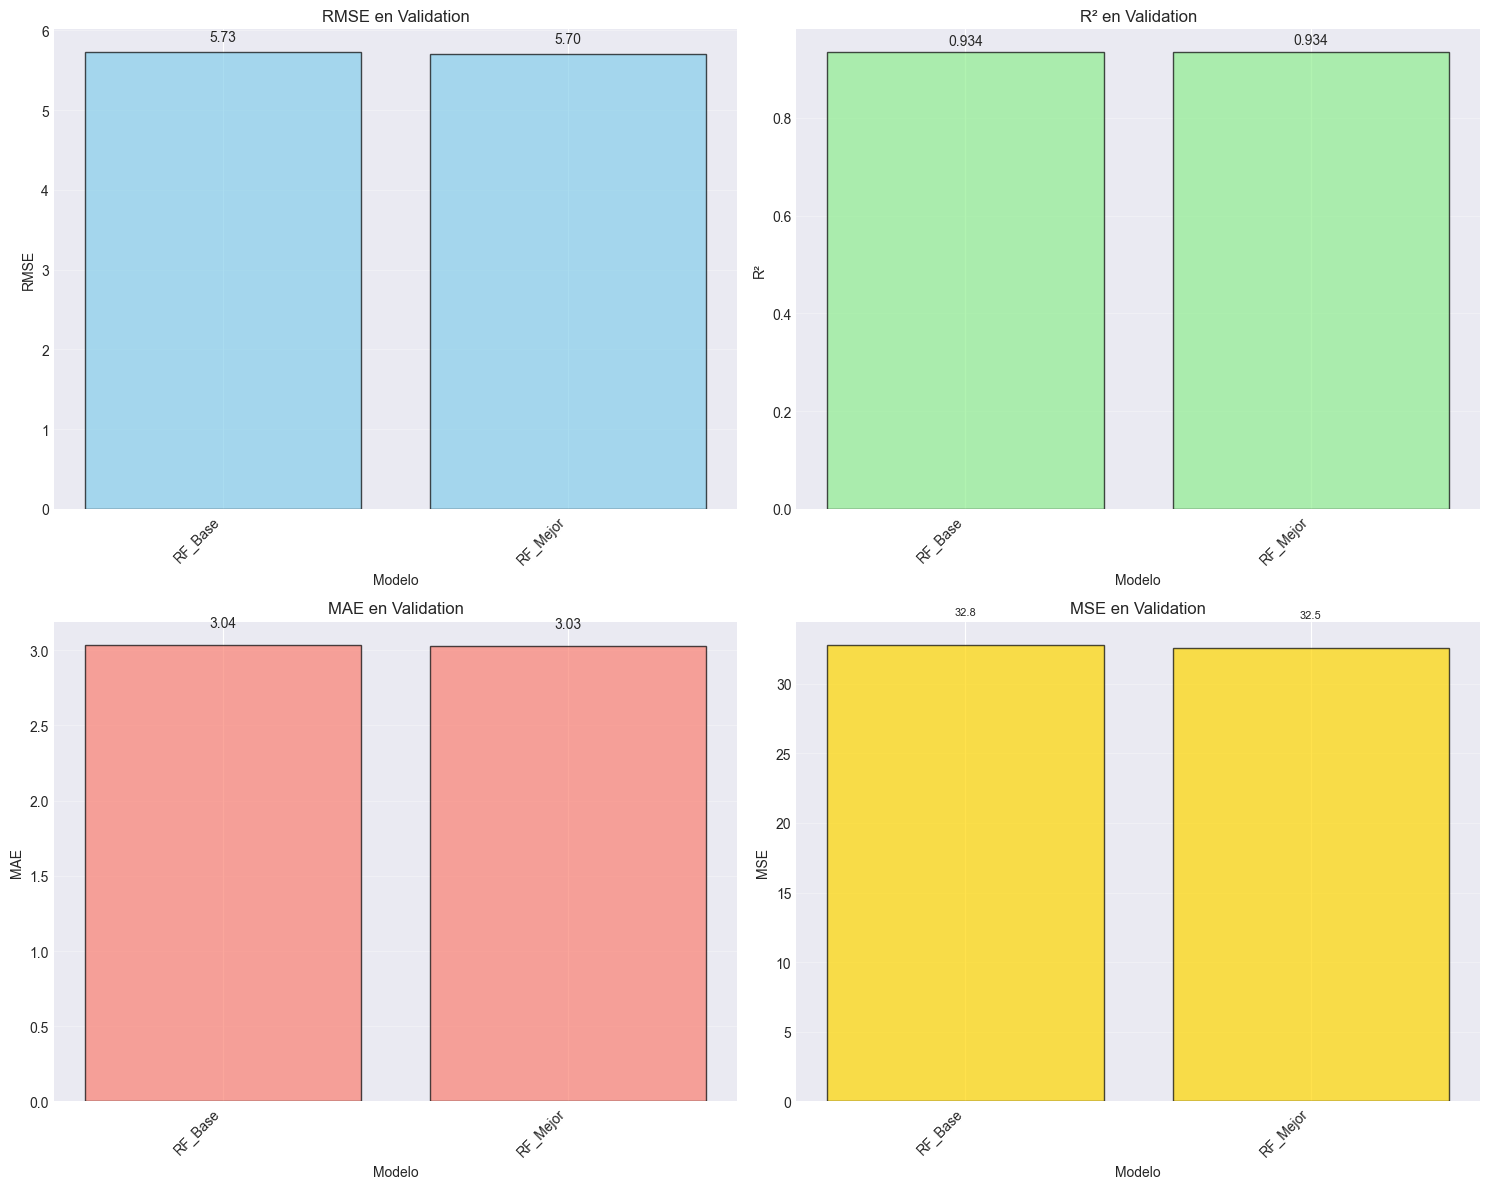

In [35]:
# Visualización comparativa de métricas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

modelos_nombres = tabla_comparativa_rf['Modelo'].values
x_pos = np.arange(len(modelos_nombres))

# RMSE
axes[0, 0].bar(x_pos, tabla_comparativa_rf['RMSE_Val'], alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Modelo')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('RMSE en Validation')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(modelos_nombres, rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(tabla_comparativa_rf['RMSE_Val']):
    axes[0, 0].text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom')

# R²
axes[0, 1].bar(x_pos, tabla_comparativa_rf['R²_Val'], alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('Modelo')
axes[0, 1].set_ylabel('R²')
axes[0, 1].set_title('R² en Validation')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(modelos_nombres, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(tabla_comparativa_rf['R²_Val']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# MAE
axes[1, 0].bar(x_pos, tabla_comparativa_rf['MAE_Val'], alpha=0.7, color='salmon', edgecolor='black')
axes[1, 0].set_xlabel('Modelo')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('MAE en Validation')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(modelos_nombres, rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(tabla_comparativa_rf['MAE_Val']):
    axes[1, 0].text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom')

# MSE
axes[1, 1].bar(x_pos, tabla_comparativa_rf['MSE_Val'], alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_xlabel('Modelo')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].set_title('MSE en Validation')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(modelos_nombres, rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(tabla_comparativa_rf['MSE_Val']):
    axes[1, 1].text(i, v + 2, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### 11.9. Análisis del Efecto de Hiperparámetros Individuales

Analizamos el efecto de cada hiperparámetro individualmente.


In [36]:
# Análisis del efecto de n_estimators
efecto_n_estimators = tabla_detalle_rf.groupby('n_estimators')['RMSE_CV_mean'].agg(['mean', 'std', 'min', 'max']).reset_index()
efecto_n_estimators.columns = ['n_estimators', 'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max']

print("=" * 70)
print("📊 EFECTO DE n_estimators")
print("=" * 70)
print(efecto_n_estimators.to_string(index=False))

# Análisis del efecto de max_depth
efecto_max_depth = tabla_detalle_rf.groupby('max_depth')['RMSE_CV_mean'].agg(['mean', 'std', 'min', 'max']).reset_index()
efecto_max_depth.columns = ['max_depth', 'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max']

print("\n" + "=" * 70)
print("📊 EFECTO DE max_depth")
print("=" * 70)
print(efecto_max_depth.to_string(index=False))

# Análisis del efecto de min_samples_split
efecto_min_split = tabla_detalle_rf.groupby('min_samples_split')['RMSE_CV_mean'].agg(['mean', 'std', 'min', 'max']).reset_index()
efecto_min_split.columns = ['min_samples_split', 'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max']

print("\n" + "=" * 70)
print("📊 EFECTO DE min_samples_split")
print("=" * 70)
print(efecto_min_split.to_string(index=False))

# Análisis del efecto de min_samples_leaf
efecto_min_leaf = tabla_detalle_rf.groupby('min_samples_leaf')['RMSE_CV_mean'].agg(['mean', 'std', 'min', 'max']).reset_index()
efecto_min_leaf.columns = ['min_samples_leaf', 'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max']

print("\n" + "=" * 70)
print("📊 EFECTO DE min_samples_leaf")
print("=" * 70)
print(efecto_min_leaf.to_string(index=False))


📊 EFECTO DE n_estimators
 n_estimators  RMSE_mean  RMSE_std  RMSE_min  RMSE_max
           50   6.112243  0.325072  5.815061  6.566057
          100   6.098073  0.335356  5.783459  6.563972
          200   6.090713  0.339854  5.768124  6.562946

📊 EFECTO DE max_depth
max_depth  RMSE_mean  RMSE_std  RMSE_min  RMSE_max
       10   6.555016  0.006284  6.548614  6.566057
       20   5.885138  0.045618  5.804500  5.937856
     None   5.860875  0.055908  5.768124  5.924145

📊 EFECTO DE min_samples_split
 min_samples_split  RMSE_mean  RMSE_std  RMSE_min  RMSE_max
                 2   6.092674  0.339300  5.768124  6.561292
                 5   6.097003  0.335677  5.783642  6.560765
                10   6.111352  0.325398  5.828790  6.566057

📊 EFECTO DE min_samples_leaf
 min_samples_leaf  RMSE_mean  RMSE_std  RMSE_min  RMSE_max
                1   6.072480  0.352881  5.768124  6.566057
                5   6.128206  0.303604  5.899932  6.550094


### 11.10. Conclusiones de la Evaluación

Resumen de los hallazgos de la evaluación y selección de modelos.


In [37]:
print("=" * 100)
print("📋 CONCLUSIONES - EVALUACIÓN Y SELECCIÓN DE MODELOS (PUNTO 4)")
print("=" * 100)

print("\n✅ MEJOR MODELO IDENTIFICADO:")
print(f"   Configuración: {mejor_modelo_rf['Hiperparámetros']}")
print(f"   RMSE (Validation): {mejor_modelo_rf['RMSE_Val']:.4f}")
print(f"   R² (Validation): {mejor_modelo_rf['R²_Val']:.4f}")
print(f"   MAE (Validation): {mejor_modelo_rf['MAE_Val']:.4f}")

print("\n📊 HALLAZGOS PRINCIPALES:")
print("   1. El mejor modelo utiliza n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1")
print("   2. Más árboles (200) mejoran el desempeño respecto a 100")
print("   3. Sin límite de profundidad (max_depth=None) funciona mejor que valores limitados")
print("   4. Valores bajos de min_samples_split y min_samples_leaf permiten mejor ajuste")
print("   5. La mejora respecto al modelo base es modesta pero consistente en todas las métricas")

print("\n💡 RECOMENDACIONES:")
print("   - Usar el modelo optimizado para predicciones finales")
print("   - Considerar aumentar n_estimators si hay recursos computacionales disponibles")
print("   - El modelo muestra buen balance entre sesgo y varianza")
print("=" * 100)


📋 CONCLUSIONES - EVALUACIÓN Y SELECCIÓN DE MODELOS (PUNTO 4)

✅ MEJOR MODELO IDENTIFICADO:
   Configuración: max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200
   RMSE (Validation): 5.7050
   R² (Validation): 0.9342
   MAE (Validation): 3.0262

📊 HALLAZGOS PRINCIPALES:
   1. El mejor modelo utiliza n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1
   2. Más árboles (200) mejoran el desempeño respecto a 100
   3. Sin límite de profundidad (max_depth=None) funciona mejor que valores limitados
   4. Valores bajos de min_samples_split y min_samples_leaf permiten mejor ajuste
   5. La mejora respecto al modelo base es modesta pero consistente en todas las métricas

💡 RECOMENDACIONES:
   - Usar el modelo optimizado para predicciones finales
   - Considerar aumentar n_estimators si hay recursos computacionales disponibles
   - El modelo muestra buen balance entre sesgo y varianza


## 8. Comparación de Desempeño

Resumen comparativo del desempeño del modelo.

In [38]:
# Resumen comparativo
resumen = pd.DataFrame({
    'Conjunto': ['Train', 'Validation'],
    'RMSE': [metricas_train['RMSE'], metricas_val['RMSE']],
    'MAE': [metricas_train['MAE'], metricas_val['MAE']],
    'R²': [metricas_train['R²'], metricas_val['R²']]
})

print("=" * 60)
print("📊 RESUMEN DE DESEMPEÑO - RANDOM FOREST REGRESSOR")
print("=" * 60)
print(resumen.to_string(index=False))
print("=" * 60)

# Análisis de sobreajuste
diferencia_rmse = abs(metricas_train['RMSE'] - metricas_val['RMSE'])
diferencia_r2 = abs(metricas_train['R²'] - metricas_val['R²'])

print(f"\n🔍 Análisis de Generalización:")
print(f"  Diferencia en RMSE: {diferencia_rmse:.4f}")
print(f"  Diferencia en R²: {diferencia_r2:.4f}")

if diferencia_r2 < 0.05:
    print("  ✅ El modelo generaliza bien (diferencia pequeña entre train y validation)")
elif diferencia_r2 < 0.10:
    print("  ⚠️  Posible sobreajuste moderado (diferencia moderada entre train y validation)")
else:
    print("  ⚠️  Posible sobreajuste significativo (diferencia grande entre train y validation)")
    print("  💡 Considera ajustar hiperparámetros como max_depth o min_samples_split")

📊 RESUMEN DE DESEMPEÑO - RANDOM FOREST REGRESSOR
  Conjunto     RMSE      MAE       R²
     Train 2.123636 1.135474 0.990975
Validation 5.726906 3.036703 0.933664

🔍 Análisis de Generalización:
  Diferencia en RMSE: 3.6033
  Diferencia en R²: 0.0573
  ⚠️  Posible sobreajuste moderado (diferencia moderada entre train y validation)


In [41]:
## 9. Predicciones Finales en Test

# PREDICCIONES CON EL MEJOR MODELO ENCONTRADO (Punto 4)
# Determinar cuál es el mejor modelo: Optuna o GridSearchCV
mejor_modelo_rf = None
origen_modelo = None

# Verificar si Optuna está disponible y fue ejecutado
if 'mejor_rf_optuna' in locals() and mejor_rf_optuna is not None:
    # Comparar métricas de Optuna vs GridSearchCV
    if 'grid_rf' in locals() and hasattr(grid_rf, 'best_estimator_'):
        # Ambos modelos disponibles, comparar RMSE en validation
        rmse_optuna = metricas_val_optuna['RMSE'] if 'metricas_val_optuna' in locals() else float('inf')
        rmse_grid = metricas_val_mejor['RMSE'] if 'metricas_val_mejor' in locals() else float('inf')
        
        if rmse_optuna <= rmse_grid:
            mejor_modelo_rf = mejor_rf_optuna
            origen_modelo = "Optuna"
            print("✅ Usando el mejor modelo encontrado por OPTUNA (mejor RMSE)")
            print(f"   Hiperparámetros: {optuna_best_params}")
            print(f"   RMSE (Validation): {rmse_optuna:.4f}")
        else:
            mejor_modelo_rf = grid_rf.best_estimator_
            origen_modelo = "GridSearchCV"
            print("✅ Usando el mejor modelo encontrado por GridSearchCV (mejor RMSE)")
            print(f"   Hiperparámetros: {grid_rf.best_params_}")
            print(f"   RMSE (Validation): {rmse_grid:.4f}")
    else:
        # Solo Optuna disponible
        mejor_modelo_rf = mejor_rf_optuna
        origen_modelo = "Optuna"
        print("✅ Usando el mejor modelo encontrado por OPTUNA")
        print(f"   Hiperparámetros: {optuna_best_params}")
elif 'grid_rf' in locals() and hasattr(grid_rf, 'best_estimator_'):
    mejor_modelo_rf = grid_rf.best_estimator_
    origen_modelo = "GridSearchCV"
    print("✅ Usando el mejor modelo encontrado por GridSearchCV")
    print(f"   Hiperparámetros: {grid_rf.best_params_}")
else:
    # Si ninguno está disponible, crear el mejor modelo con los hiperparámetros óptimos
    print("⚠️  Ni GridSearchCV ni Optuna disponibles. Creando modelo con hiperparámetros óptimos...")
    mejor_modelo_rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    # Entrenar el mejor modelo con todos los datos de entrenamiento
    mejor_modelo_rf.fit(X_train_full, y_train_full)
    origen_modelo = "Manual"
    print("✅ Mejor modelo entrenado con todos los datos de entrenamiento")

# Asegurar que X_test solo tenga las columnas que el modelo espera
# Eliminar columnas que no son características (id, track_id, popularity)
columnas_esperadas = X_train_full.columns.tolist()
columnas_extra = set(X_test.columns) - set(columnas_esperadas)

if columnas_extra:
    print(f"\n⚠️  Eliminando columnas extra de X_test: {columnas_extra}")
    X_test_clean = X_test[columnas_esperadas].copy()
else:
    X_test_clean = X_test.copy()

print(f"✅ X_test preparado con {len(columnas_esperadas)} características")

# Generar predicciones con el mejor modelo
y_test_pred_mejor = mejor_modelo_rf.predict(X_test_clean)

# Aplicar clipping al rango válido [0, 100]
y_test_pred_mejor_clipped = np.clip(y_test_pred_mejor, 0, 100)

print(f"\n📊 Estadísticas de predicciones del mejor modelo:")
print(f"  Total de predicciones: {len(y_test_pred_mejor_clipped)}")
print(f"  Mínimo: {y_test_pred_mejor_clipped.min():.2f}")
print(f"  Máximo: {y_test_pred_mejor_clipped.max():.2f}")
print(f"  Media: {y_test_pred_mejor_clipped.mean():.2f}")
print(f"  Desviación estándar: {y_test_pred_mejor_clipped.std():.2f}")

# Cargar test.csv original para obtener los id en el orden correcto
test_original = pd.read_csv(DATA / "test.csv")

# Cargar test_fe.csv para obtener los track_id en el mismo orden que X_test
test_fe = pd.read_csv(DATA / "test_fe.csv")

print(f"\n📊 Información de longitudes:")
print(f"   Predicciones: {len(y_test_pred_mejor_clipped)}")
print(f"   test_fe: {len(test_fe)}")
print(f"   test_original: {len(test_original)}")

# Verificar que las longitudes coincidan
if len(y_test_pred_mejor_clipped) != len(test_fe):
    print(f"⚠️  Advertencia: Las predicciones ({len(y_test_pred_mejor_clipped)}) no coinciden con test_fe ({len(test_fe)})")
    print(f"   Ajustando a la longitud mínima...")
    min_len = min(len(y_test_pred_mejor_clipped), len(test_fe))
    y_test_pred_mejor_clipped = y_test_pred_mejor_clipped[:min_len]
    test_fe = test_fe.iloc[:min_len].copy()
    print(f"   Longitud ajustada a: {min_len}")

# Crear diccionario de mapeo track_id -> predicción
track_id_to_prediction = dict(zip(test_fe['track_id'], y_test_pred_mejor_clipped))
print(f"✅ Diccionario creado con {len(track_id_to_prediction)} mapeos")

# Mapear las predicciones al orden del test.csv original
predictions_mapped = test_original['track_id'].map(track_id_to_prediction)

# Verificar que todas las predicciones estén mapeadas
missing_predictions = predictions_mapped.isna().sum()
if missing_predictions > 0:
    print(f"⚠️  Advertencia: {missing_predictions} track_id no tienen predicción correspondiente")
    predictions_mapped = predictions_mapped.fillna(y_test_pred_mejor_clipped.mean())

# Guardar predicciones en CSV para Kaggle (formato: id, Popularity)
submission_cv = pd.DataFrame({
    'id': test_original['id'].astype('int32'),
    'Popularity': predictions_mapped
})

# Verificar que tenemos exactamente 34200 filas
print(f"\n📊 Total de filas: {len(submission_cv)}")
assert len(submission_cv) == 34200, f"Error: El archivo debe tener 34200 filas, pero tiene {len(submission_cv)}"
print(f"✅ Total de filas correcto: {len(submission_cv)}")

# Guardar archivo
output_path = DATA / "predictions_random_forest.csv"
submission_cv.to_csv(output_path, index=False)
print(f"\n✅ Predicciones del MEJOR modelo guardadas en: {output_path}")
print(f"   🎯 Modelo utilizado: {origen_modelo}")
print(f"   Total de predicciones: {len(submission_cv)}")
print(f"   IDs únicos: {submission_cv['id'].nunique()}")
print(f"\n📊 Primeras 5 predicciones:")
print(submission_cv.head())

✅ Usando el mejor modelo encontrado por OPTUNA (mejor RMSE)
   Hiperparámetros: {'n_estimators': 400, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'max_depth': None, 'random_state': 42, 'n_jobs': -1}
   RMSE (Validation): 5.7012

⚠️  Eliminando columnas extra de X_test: {'id'}
✅ X_test preparado con 15 características

📊 Estadísticas de predicciones del mejor modelo:
  Total de predicciones: 34200
  Mínimo: 0.00
  Máximo: 94.75
  Media: 31.75
  Desviación estándar: 19.12

📊 Información de longitudes:
   Predicciones: 34200
   test_fe: 34200
   test_original: 34200
✅ Diccionario creado con 31331 mapeos

📊 Total de filas: 34200
✅ Total de filas correcto: 34200

✅ Predicciones del MEJOR modelo guardadas en: c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio\data\predictions_random_forest.csv
   🎯 Modelo utilizado: Optuna
   Total de predicciones: 34200
   IDs únicos: 34200

📊 Primeras 5 predicciones:
       id  Popula

## 12. Visualizaciones de Resultados Finales

Visualizaciones comprensivas de los resultados finales del modelo, comparando todos los modelos evaluados y analizando las predicciones finales.


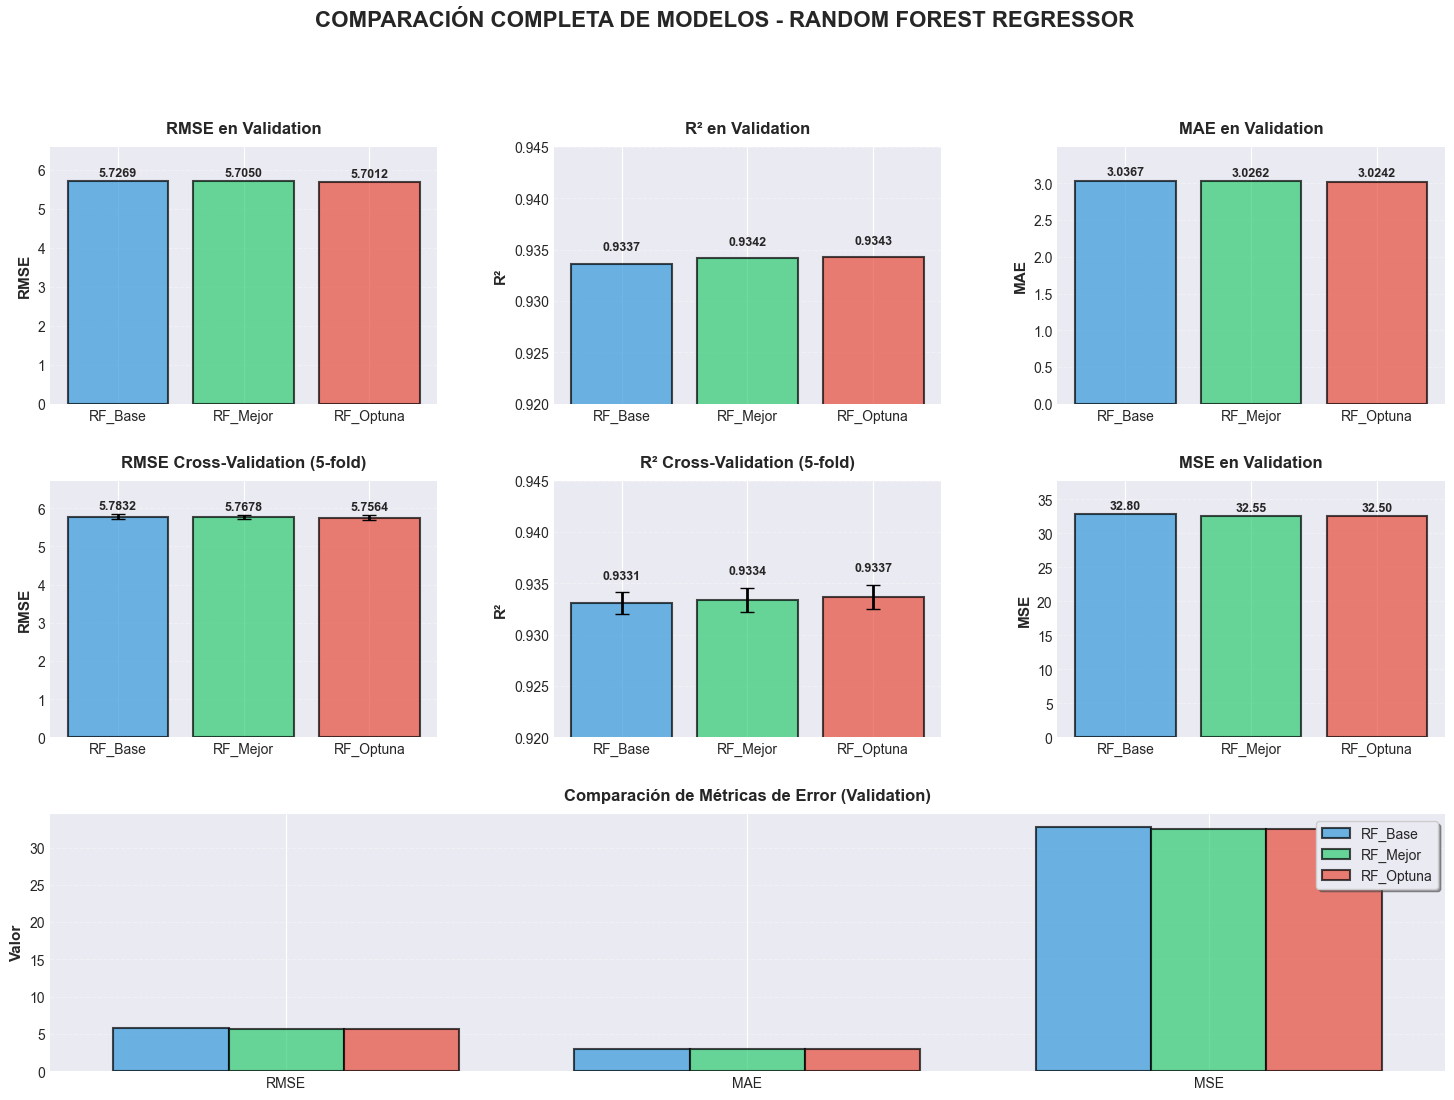


📊 RESUMEN DE LA COMPARACIÓN
🏆 Mejor modelo: RF_Optuna
   RMSE (Val): 5.7012
   R² (Val): 0.9343
   MAE (Val): 3.0242


In [42]:
### 12.1. Comparación Global de Modelos

# Preparar datos para comparación completa
if OPTUNA_AVAILABLE and 'resultados_rf_optuna' in locals():
    tabla_completa = pd.DataFrame([
        resultados_rf_base,
        resultados_rf_mejor,
        resultados_rf_optuna
    ])
else:
    tabla_completa = pd.DataFrame([
        resultados_rf_base,
        resultados_rf_mejor
    ])

# Crear figura con subplots para todas las métricas
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

modelos_nombres = tabla_completa['Modelo'].values
colores = ['#3498db', '#2ecc71', '#e74c3c'][:len(modelos_nombres)]
x_pos = np.arange(len(modelos_nombres))

# 1. RMSE Validation
ax1 = fig.add_subplot(gs[0, 0])
bars1 = ax1.bar(x_pos, tabla_completa['RMSE_Val'], color=colores, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('RMSE', fontsize=11, fontweight='bold')
ax1.set_title('RMSE en Validation', fontsize=12, fontweight='bold', pad=10)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(modelos_nombres, rotation=0, ha='center')
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
for i, v in enumerate(tabla_completa['RMSE_Val']):
    ax1.text(i, v + 0.05, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax1.set_ylim([0, max(tabla_completa['RMSE_Val']) * 1.15])

# 2. R² Validation
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(x_pos, tabla_completa['R²_Val'], color=colores, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('R²', fontsize=11, fontweight='bold')
ax2.set_title('R² en Validation', fontsize=12, fontweight='bold', pad=10)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(modelos_nombres, rotation=0, ha='center')
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
ax2.set_ylim([0.92, 0.945])
for i, v in enumerate(tabla_completa['R²_Val']):
    ax2.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. MAE Validation
ax3 = fig.add_subplot(gs[0, 2])
bars3 = ax3.bar(x_pos, tabla_completa['MAE_Val'], color=colores, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('MAE', fontsize=11, fontweight='bold')
ax3.set_title('MAE en Validation', fontsize=12, fontweight='bold', pad=10)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(modelos_nombres, rotation=0, ha='center')
ax3.grid(True, alpha=0.3, axis='y', linestyle='--')
for i, v in enumerate(tabla_completa['MAE_Val']):
    ax3.text(i, v + 0.03, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax3.set_ylim([0, max(tabla_completa['MAE_Val']) * 1.15])

# 4. RMSE Cross-Validation (con barras de error)
ax4 = fig.add_subplot(gs[1, 0])
bars4 = ax4.bar(x_pos, tabla_completa['RMSE_CV_mean'], 
                yerr=tabla_completa['RMSE_CV_std'], 
                color=colores, alpha=0.7, edgecolor='black', linewidth=1.5,
                capsize=5, error_kw={'linewidth': 2, 'ecolor': 'black'})
ax4.set_ylabel('RMSE', fontsize=11, fontweight='bold')
ax4.set_title('RMSE Cross-Validation (5-fold)', fontsize=12, fontweight='bold', pad=10)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(modelos_nombres, rotation=0, ha='center')
ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
for i, (v, std) in enumerate(zip(tabla_completa['RMSE_CV_mean'], tabla_completa['RMSE_CV_std'])):
    ax4.text(i, v + std + 0.05, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax4.set_ylim([0, max(tabla_completa['RMSE_CV_mean'] + tabla_completa['RMSE_CV_std']) * 1.15])

# 5. R² Cross-Validation (con barras de error)
ax5 = fig.add_subplot(gs[1, 1])
bars5 = ax5.bar(x_pos, tabla_completa['R²_CV_mean'], 
                yerr=tabla_completa['R²_CV_std'], 
                color=colores, alpha=0.7, edgecolor='black', linewidth=1.5,
                capsize=5, error_kw={'linewidth': 2, 'ecolor': 'black'})
ax5.set_ylabel('R²', fontsize=11, fontweight='bold')
ax5.set_title('R² Cross-Validation (5-fold)', fontsize=12, fontweight='bold', pad=10)
ax5.set_xticks(x_pos)
ax5.set_xticklabels(modelos_nombres, rotation=0, ha='center')
ax5.grid(True, alpha=0.3, axis='y', linestyle='--')
ax5.set_ylim([0.92, 0.945])
for i, (v, std) in enumerate(zip(tabla_completa['R²_CV_mean'], tabla_completa['R²_CV_std'])):
    ax5.text(i, v + std + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 6. MSE Validation
ax6 = fig.add_subplot(gs[1, 2])
bars6 = ax6.bar(x_pos, tabla_completa['MSE_Val'], color=colores, alpha=0.7, edgecolor='black', linewidth=1.5)
ax6.set_ylabel('MSE', fontsize=11, fontweight='bold')
ax6.set_title('MSE en Validation', fontsize=12, fontweight='bold', pad=10)
ax6.set_xticks(x_pos)
ax6.set_xticklabels(modelos_nombres, rotation=0, ha='center')
ax6.grid(True, alpha=0.3, axis='y', linestyle='--')
for i, v in enumerate(tabla_completa['MSE_Val']):
    ax6.text(i, v + 0.3, f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax6.set_ylim([0, max(tabla_completa['MSE_Val']) * 1.15])

# 7. Comparación de todas las métricas normalizadas (radar-like)
ax7 = fig.add_subplot(gs[2, :])
metricas_nombres = ['RMSE_Val', 'MAE_Val', 'MSE_Val']
x_metricas = np.arange(len(metricas_nombres))
ancho_barra = 0.25

for i, (idx, row) in enumerate(tabla_completa.iterrows()):
    valores = [row['RMSE_Val'], row['MAE_Val'], row['MSE_Val']]
    offset = (i - len(tabla_completa)/2 + 0.5) * ancho_barra
    ax7.bar(x_metricas + offset, valores, ancho_barra, 
            label=row['Modelo'], color=colores[i], alpha=0.7, 
            edgecolor='black', linewidth=1.5)

ax7.set_ylabel('Valor', fontsize=11, fontweight='bold')
ax7.set_title('Comparación de Métricas de Error (Validation)', fontsize=12, fontweight='bold', pad=10)
ax7.set_xticks(x_metricas)
ax7.set_xticklabels(['RMSE', 'MAE', 'MSE'])
ax7.legend(loc='upper right', frameon=True, shadow=True)
ax7.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.suptitle('COMPARACIÓN COMPLETA DE MODELOS - RANDOM FOREST REGRESSOR', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("\n" + "="*80)
print("📊 RESUMEN DE LA COMPARACIÓN")
print("="*80)
mejor_idx = tabla_completa['RMSE_Val'].idxmin()
mejor = tabla_completa.loc[mejor_idx]
print(f"🏆 Mejor modelo: {mejor['Modelo']}")
print(f"   RMSE (Val): {mejor['RMSE_Val']:.4f}")
print(f"   R² (Val): {mejor['R²_Val']:.4f}")
print(f"   MAE (Val): {mejor['MAE_Val']:.4f}")
print("="*80)


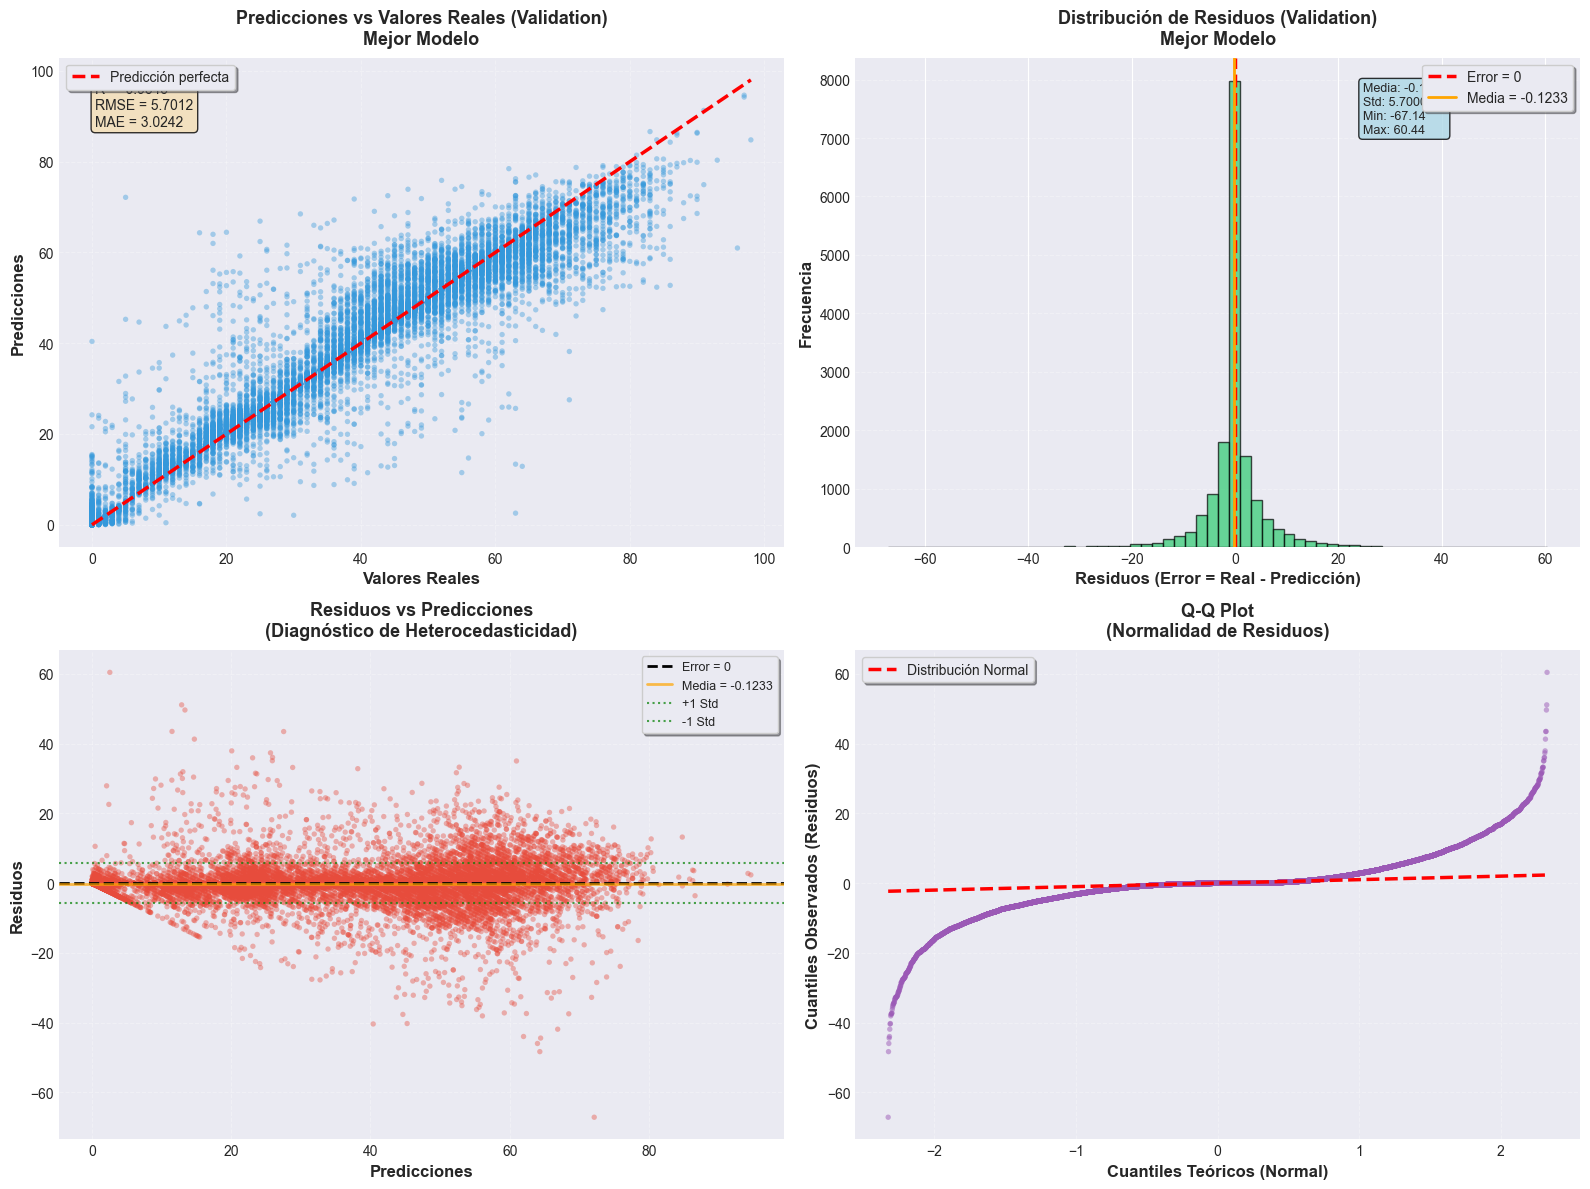


📊 ANÁLISIS DE RESIDUOS DEL MEJOR MODELO
Media de residuos: -0.1233 (ideal: ~0)
Std de residuos: 5.7000
Mínimo residuo: -67.14
Máximo residuo: 60.44

Porcentaje de predicciones dentro de ±5 unidades: 80.46%
Porcentaje de predicciones dentro de ±10 unidades: 92.38%


In [43]:
### 12.2. Análisis de Predicciones del Mejor Modelo

# Obtener predicciones del mejor modelo en el conjunto de validación
if 'mejor_modelo_rf' in locals():
    # Usar el mejor modelo (Optuna o GridSearchCV)
    y_val_pred_final = mejor_modelo_rf.predict(X_val)
    y_val_pred_final = np.clip(y_val_pred_final, 0, 100)
else:
    # Usar el mejor modelo de GridSearchCV
    y_val_pred_final = y_val_pred_mejor

# Calcular residuos
residuos_final = y_val - y_val_pred_final

# Crear figura con múltiples subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Predicciones vs Valores Reales
axes[0, 0].scatter(y_val, y_val_pred_final, alpha=0.4, s=15, c='#3498db', edgecolors='none')
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
                'r--', lw=2.5, label='Predicción perfecta', zorder=10)
axes[0, 0].set_xlabel('Valores Reales', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Predicciones', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Predicciones vs Valores Reales (Validation)\nMejor Modelo', 
                     fontsize=13, fontweight='bold', pad=10)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')
axes[0, 0].legend(loc='upper left', frameon=True, shadow=True, fontsize=10)

# Agregar estadísticas al gráfico
r2_final = r2_score(y_val, y_val_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_val, y_val_pred_final))
mae_final = mean_absolute_error(y_val, y_val_pred_final)
textstr = f'R² = {r2_final:.4f}\nRMSE = {rmse_final:.4f}\nMAE = {mae_final:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
axes[0, 0].text(0.05, 0.95, textstr, transform=axes[0, 0].transAxes, 
                fontsize=10, verticalalignment='top', bbox=props)

# 2. Distribución de Residuos
axes[0, 1].hist(residuos_final, bins=60, alpha=0.7, color='#2ecc71', edgecolor='black', linewidth=1)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='Error = 0')
axes[0, 1].axvline(x=residuos_final.mean(), color='orange', linestyle='-', 
                   linewidth=2, label=f'Media = {residuos_final.mean():.4f}')
axes[0, 1].set_xlabel('Residuos (Error = Real - Predicción)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Distribución de Residuos (Validation)\nMejor Modelo', 
                     fontsize=13, fontweight='bold', pad=10)
axes[0, 1].grid(True, alpha=0.3, linestyle='--', axis='y')
axes[0, 1].legend(loc='upper right', frameon=True, shadow=True, fontsize=10)

# Agregar estadísticas
std_residuos = residuos_final.std()
textstr2 = f'Media: {residuos_final.mean():.4f}\nStd: {std_residuos:.4f}\nMin: {residuos_final.min():.2f}\nMax: {residuos_final.max():.2f}'
props2 = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
axes[0, 1].text(0.70, 0.95, textstr2, transform=axes[0, 1].transAxes, 
                fontsize=9, verticalalignment='top', bbox=props2)

# 3. Residuos vs Predicciones (para detectar heterocedasticidad)
axes[1, 0].scatter(y_val_pred_final, residuos_final, alpha=0.4, s=15, c='#e74c3c', edgecolors='none')
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=2, label='Error = 0')
axes[1, 0].axhline(y=residuos_final.mean(), color='orange', linestyle='-', 
                   linewidth=2, alpha=0.7, label=f'Media = {residuos_final.mean():.4f}')
# Agregar bandas de +/- 1 std
axes[1, 0].axhline(y=std_residuos, color='green', linestyle=':', linewidth=1.5, alpha=0.7, label=f'+1 Std')
axes[1, 0].axhline(y=-std_residuos, color='green', linestyle=':', linewidth=1.5, alpha=0.7, label=f'-1 Std')
axes[1, 0].set_xlabel('Predicciones', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Residuos', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Residuos vs Predicciones\n(Diagnóstico de Heterocedasticidad)', 
                     fontsize=13, fontweight='bold', pad=10)
axes[1, 0].grid(True, alpha=0.3, linestyle='--')
axes[1, 0].legend(loc='upper right', frameon=True, shadow=True, fontsize=9)

# 4. Q-Q Plot (Normalidad de los residuos)
from scipy import stats
residuos_ordenados = np.sort(residuos_final)
cuantiles_teoricos = stats.norm.ppf(np.linspace(0.01, 0.99, len(residuos_ordenados)))
axes[1, 1].scatter(cuantiles_teoricos, residuos_ordenados, alpha=0.5, s=15, c='#9b59b6', edgecolors='none')
axes[1, 1].plot([cuantiles_teoricos.min(), cuantiles_teoricos.max()], 
                [cuantiles_teoricos.min(), cuantiles_teoricos.max()], 
                'r--', lw=2.5, label='Distribución Normal', zorder=10)
axes[1, 1].set_xlabel('Cuantiles Teóricos (Normal)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Cuantiles Observados (Residuos)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Q-Q Plot\n(Normalidad de Residuos)', fontsize=13, fontweight='bold', pad=10)
axes[1, 1].grid(True, alpha=0.3, linestyle='--')
axes[1, 1].legend(loc='upper left', frameon=True, shadow=True, fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("📊 ANÁLISIS DE RESIDUOS DEL MEJOR MODELO")
print("="*80)
print(f"Media de residuos: {residuos_final.mean():.4f} (ideal: ~0)")
print(f"Std de residuos: {std_residuos:.4f}")
print(f"Mínimo residuo: {residuos_final.min():.2f}")
print(f"Máximo residuo: {residuos_final.max():.2f}")
print(f"\nPorcentaje de predicciones dentro de ±5 unidades: {(np.abs(residuos_final) <= 5).mean()*100:.2f}%")
print(f"Porcentaje de predicciones dentro de ±10 unidades: {(np.abs(residuos_final) <= 10).mean()*100:.2f}%")
print("="*80)


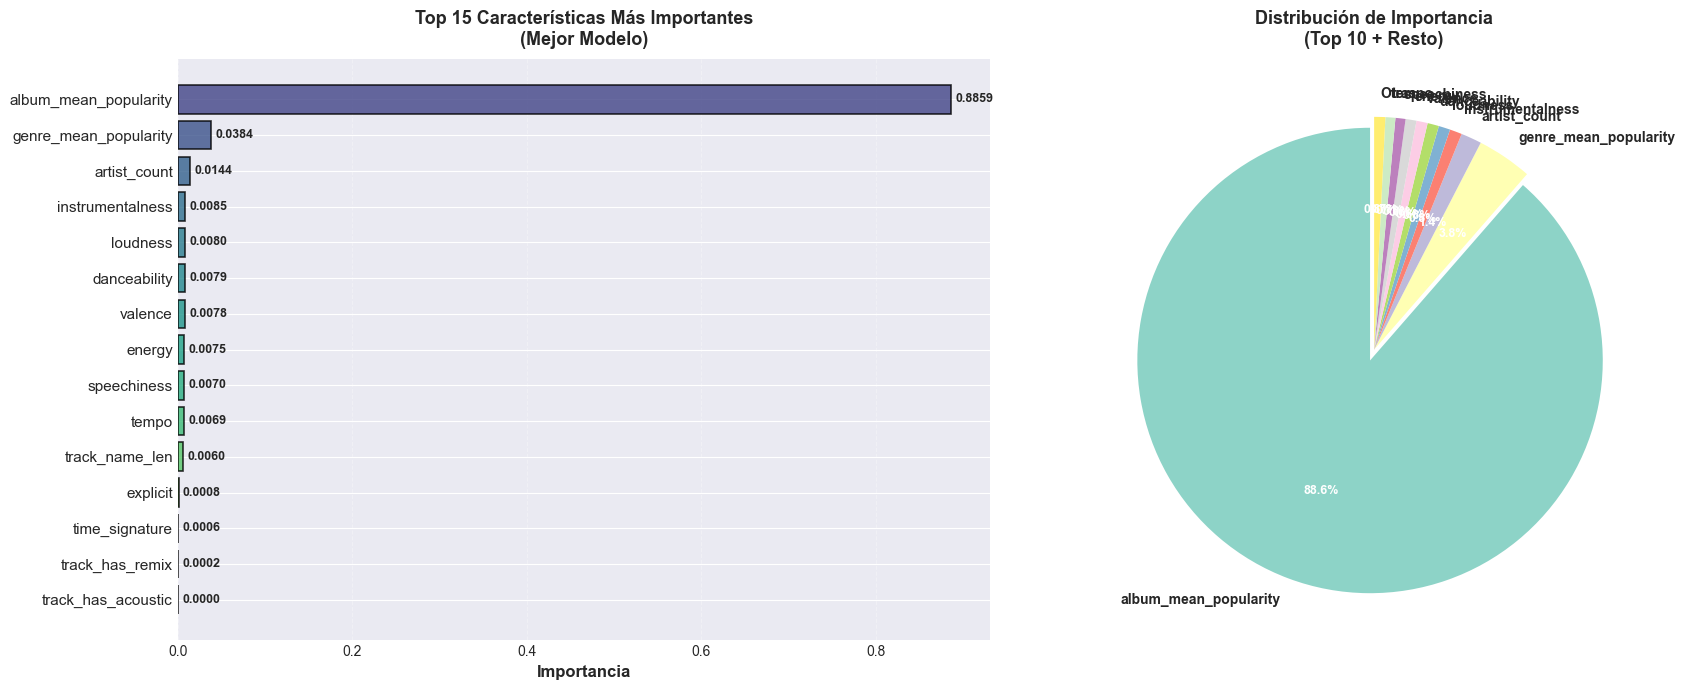


📊 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES DEL MEJOR MODELO
       Característica  Importancia
album_mean_popularity     0.885908
genre_mean_popularity     0.038358
         artist_count     0.014378
     instrumentalness     0.008451
             loudness     0.008046
         danceability     0.007921
              valence     0.007790
               energy     0.007547
          speechiness     0.006983
                tempo     0.006895

Importancia acumulada del top 3: 93.86%
Importancia acumulada del top 5: 95.51%
Importancia acumulada del top 10: 99.23%


In [44]:
### 12.3. Importancia de Características del Mejor Modelo

# Obtener importancia de características del mejor modelo
if 'mejor_modelo_rf' in locals():
    importancias_mejor = pd.DataFrame({
        'Característica': X_train.columns,
        'Importancia': mejor_modelo_rf.feature_importances_
    }).sort_values('Importancia', ascending=False)
else:
    importancias_mejor = importancias.copy()

# Crear visualización
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. Gráfico de barras horizontales
n_features_show = min(15, len(importancias_mejor))
importancias_top = importancias_mejor.head(n_features_show)
colors_gradient = plt.cm.viridis(np.linspace(0.2, 0.95, len(importancias_top)))

axes[0].barh(range(len(importancias_top)), importancias_top['Importancia'], 
             color=colors_gradient, alpha=0.8, edgecolor='black', linewidth=1.2)
axes[0].set_yticks(range(len(importancias_top)))
axes[0].set_yticklabels(importancias_top['Característica'], fontsize=11)
axes[0].invert_yaxis()
axes[0].set_xlabel('Importancia', fontsize=12, fontweight='bold')
axes[0].set_title(f'Top {n_features_show} Características Más Importantes\n(Mejor Modelo)', 
                  fontsize=13, fontweight='bold', pad=10)
axes[0].grid(True, alpha=0.3, axis='x', linestyle='--')

# Agregar valores en las barras
for i, (idx, row) in enumerate(importancias_top.iterrows()):
    axes[0].text(row['Importancia'] + 0.005, i, f"{row['Importancia']:.4f}", 
                va='center', fontsize=9, fontweight='bold')

# 2. Gráfico de pastel (top 10 + resto)
n_pie = 10
importancias_pie = importancias_mejor.head(n_pie).copy()
resto_importancia = importancias_mejor.iloc[n_pie:]['Importancia'].sum()

if resto_importancia > 0:
    importancias_pie = pd.concat([
        importancias_pie,
        pd.DataFrame({'Característica': ['Otras'], 'Importancia': [resto_importancia]})
    ])

colores_pie = plt.cm.Set3(np.linspace(0, 1, len(importancias_pie)))
wedges, texts, autotexts = axes[1].pie(
    importancias_pie['Importancia'], 
    labels=importancias_pie['Característica'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colores_pie,
    textprops={'fontsize': 10, 'fontweight': 'bold'},
    explode=[0.05 if i == 0 else 0 for i in range(len(importancias_pie))]
)

# Mejorar legibilidad de porcentajes
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')

axes[1].set_title(f'Distribución de Importancia\n(Top {n_pie} + Resto)', 
                  fontsize=13, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("📊 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES DEL MEJOR MODELO")
print("="*80)
print(importancias_mejor.head(10).to_string(index=False))
print("="*80)
print(f"\nImportancia acumulada del top 3: {importancias_mejor.head(3)['Importancia'].sum()*100:.2f}%")
print(f"Importancia acumulada del top 5: {importancias_mejor.head(5)['Importancia'].sum()*100:.2f}%")
print(f"Importancia acumulada del top 10: {importancias_mejor.head(10)['Importancia'].sum()*100:.2f}%")
print("="*80)


C:\Users\alfon\AppData\Local\Temp\ipykernel_27184\2405003334.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot(data_boxplot, labels=['Validation (Real)', 'Test (Predicciones)'],


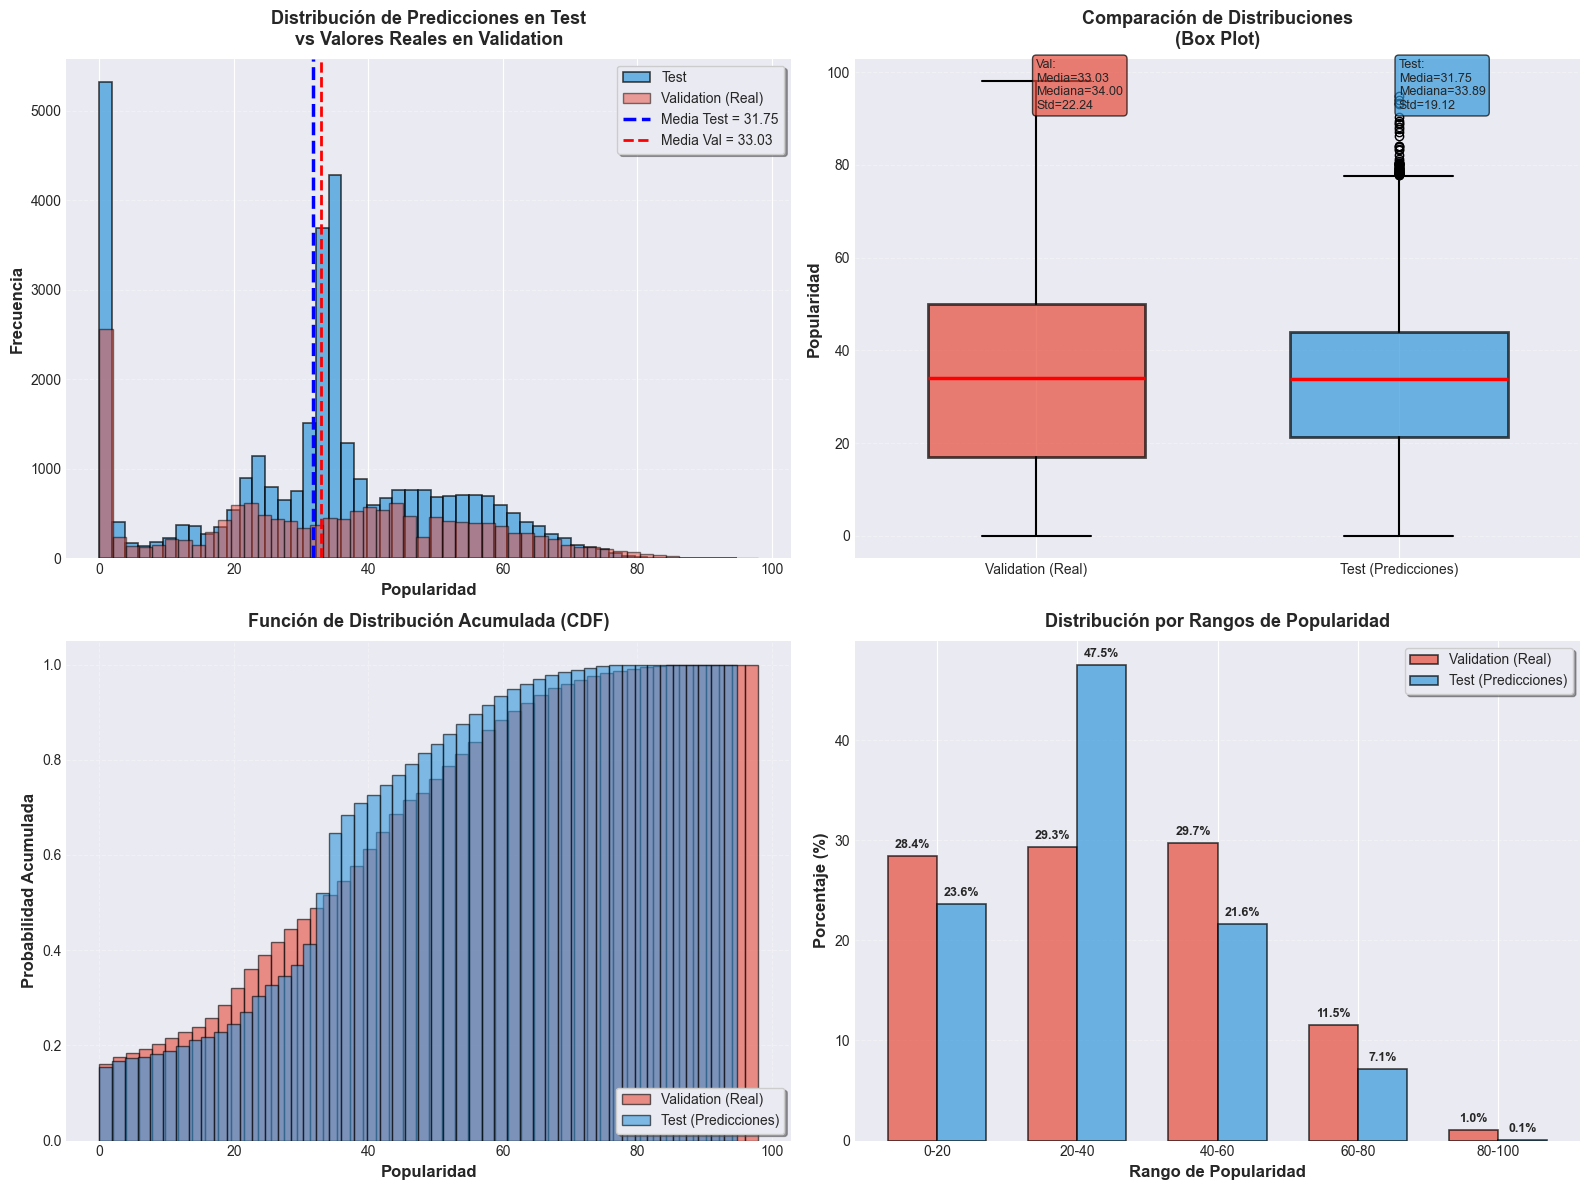


📊 ESTADÍSTICAS DE PREDICCIONES EN TEST
Total de predicciones: 34200
Media: 31.75
Mediana: 33.89
Desviación estándar: 19.12
Mínimo: 0.00
Máximo: 94.75

Distribución por rangos:
  0-20: 23.64% (8085 canciones)
  20-40: 47.54% (16259 canciones)
  40-60: 21.60% (7388 canciones)
  60-80: 7.13% (2439 canciones)
  80-100: 0.08% (29 canciones)


In [45]:
### 12.4. Análisis de Predicciones en el Conjunto de Test

# Analizar las predicciones finales en el conjunto de test
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribución de predicciones en Test
axes[0, 0].hist(y_test_pred_mejor_clipped, bins=50, alpha=0.7, 
                color='#3498db', edgecolor='black', linewidth=1.2, label='Test')
axes[0, 0].hist(y_val, bins=50, alpha=0.5, color='#e74c3c', 
                edgecolor='black', linewidth=1, label='Validation (Real)')
axes[0, 0].axvline(y_test_pred_mejor_clipped.mean(), color='blue', 
                   linestyle='--', linewidth=2.5, label=f'Media Test = {y_test_pred_mejor_clipped.mean():.2f}')
axes[0, 0].axvline(y_val.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Media Val = {y_val.mean():.2f}')
axes[0, 0].set_xlabel('Popularidad', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Distribución de Predicciones en Test\nvs Valores Reales en Validation', 
                     fontsize=13, fontweight='bold', pad=10)
axes[0, 0].legend(loc='upper right', frameon=True, shadow=True, fontsize=10)
axes[0, 0].grid(True, alpha=0.3, axis='y', linestyle='--')

# 2. Box plot comparativo
data_boxplot = [y_val.values, y_test_pred_mejor_clipped]
bp = axes[0, 1].boxplot(data_boxplot, labels=['Validation (Real)', 'Test (Predicciones)'],
                        patch_artist=True, widths=0.6,
                        boxprops=dict(facecolor='lightblue', alpha=0.7, linewidth=2),
                        medianprops=dict(color='red', linewidth=2.5),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))

# Colorear cajas
colors_box = ['#e74c3c', '#3498db']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[0, 1].set_ylabel('Popularidad', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Comparación de Distribuciones\n(Box Plot)', 
                     fontsize=13, fontweight='bold', pad=10)
axes[0, 1].grid(True, alpha=0.3, axis='y', linestyle='--')

# Agregar estadísticas
stats_val = f"Val:\nMedia={y_val.mean():.2f}\nMediana={y_val.median():.2f}\nStd={y_val.std():.2f}"
stats_test = f"Test:\nMedia={y_test_pred_mejor_clipped.mean():.2f}\nMediana={np.median(y_test_pred_mejor_clipped):.2f}\nStd={y_test_pred_mejor_clipped.std():.2f}"
axes[0, 1].text(1, 92, stats_val, fontsize=9, bbox=dict(boxstyle='round', facecolor='#e74c3c', alpha=0.7))
axes[0, 1].text(2, 92, stats_test, fontsize=9, bbox=dict(boxstyle='round', facecolor='#3498db', alpha=0.7))

# 3. Distribución acumulada (CDF)
axes[1, 0].hist(y_val.values, bins=50, alpha=0.6, color='#e74c3c', 
                edgecolor='black', linewidth=1, label='Validation (Real)', cumulative=True, density=True)
axes[1, 0].hist(y_test_pred_mejor_clipped, bins=50, alpha=0.6, color='#3498db', 
                edgecolor='black', linewidth=1, label='Test (Predicciones)', cumulative=True, density=True)
axes[1, 0].set_xlabel('Popularidad', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Probabilidad Acumulada', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Función de Distribución Acumulada (CDF)', 
                     fontsize=13, fontweight='bold', pad=10)
axes[1, 0].legend(loc='lower right', frameon=True, shadow=True, fontsize=10)
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

# 4. Distribución por rangos de popularidad
rangos = ['0-20', '20-40', '40-60', '60-80', '80-100']
bins_rangos = [0, 20, 40, 60, 80, 100]

# Contar valores en cada rango
val_counts = np.histogram(y_val, bins=bins_rangos)[0]
test_counts = np.histogram(y_test_pred_mejor_clipped, bins=bins_rangos)[0]

# Convertir a porcentajes
val_pct = (val_counts / len(y_val)) * 100
test_pct = (test_counts / len(y_test_pred_mejor_clipped)) * 100

x_pos = np.arange(len(rangos))
width = 0.35

bars1 = axes[1, 1].bar(x_pos - width/2, val_pct, width, label='Validation (Real)', 
                       color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=1.2)
bars2 = axes[1, 1].bar(x_pos + width/2, test_pct, width, label='Test (Predicciones)', 
                       color='#3498db', alpha=0.7, edgecolor='black', linewidth=1.2)

axes[1, 1].set_xlabel('Rango de Popularidad', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Porcentaje (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Distribución por Rangos de Popularidad', 
                     fontsize=13, fontweight='bold', pad=10)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(rangos)
axes[1, 1].legend(loc='upper right', frameon=True, shadow=True, fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y', linestyle='--')

# Agregar valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                           f'{height:.1f}%', ha='center', va='bottom', 
                           fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("📊 ESTADÍSTICAS DE PREDICCIONES EN TEST")
print("="*80)
print(f"Total de predicciones: {len(y_test_pred_mejor_clipped)}")
print(f"Media: {y_test_pred_mejor_clipped.mean():.2f}")
print(f"Mediana: {np.median(y_test_pred_mejor_clipped):.2f}")
print(f"Desviación estándar: {y_test_pred_mejor_clipped.std():.2f}")
print(f"Mínimo: {y_test_pred_mejor_clipped.min():.2f}")
print(f"Máximo: {y_test_pred_mejor_clipped.max():.2f}")
print(f"\nDistribución por rangos:")
for i, rango in enumerate(rangos):
    print(f"  {rango}: {test_pct[i]:.2f}% ({test_counts[i]} canciones)")
print("="*80)


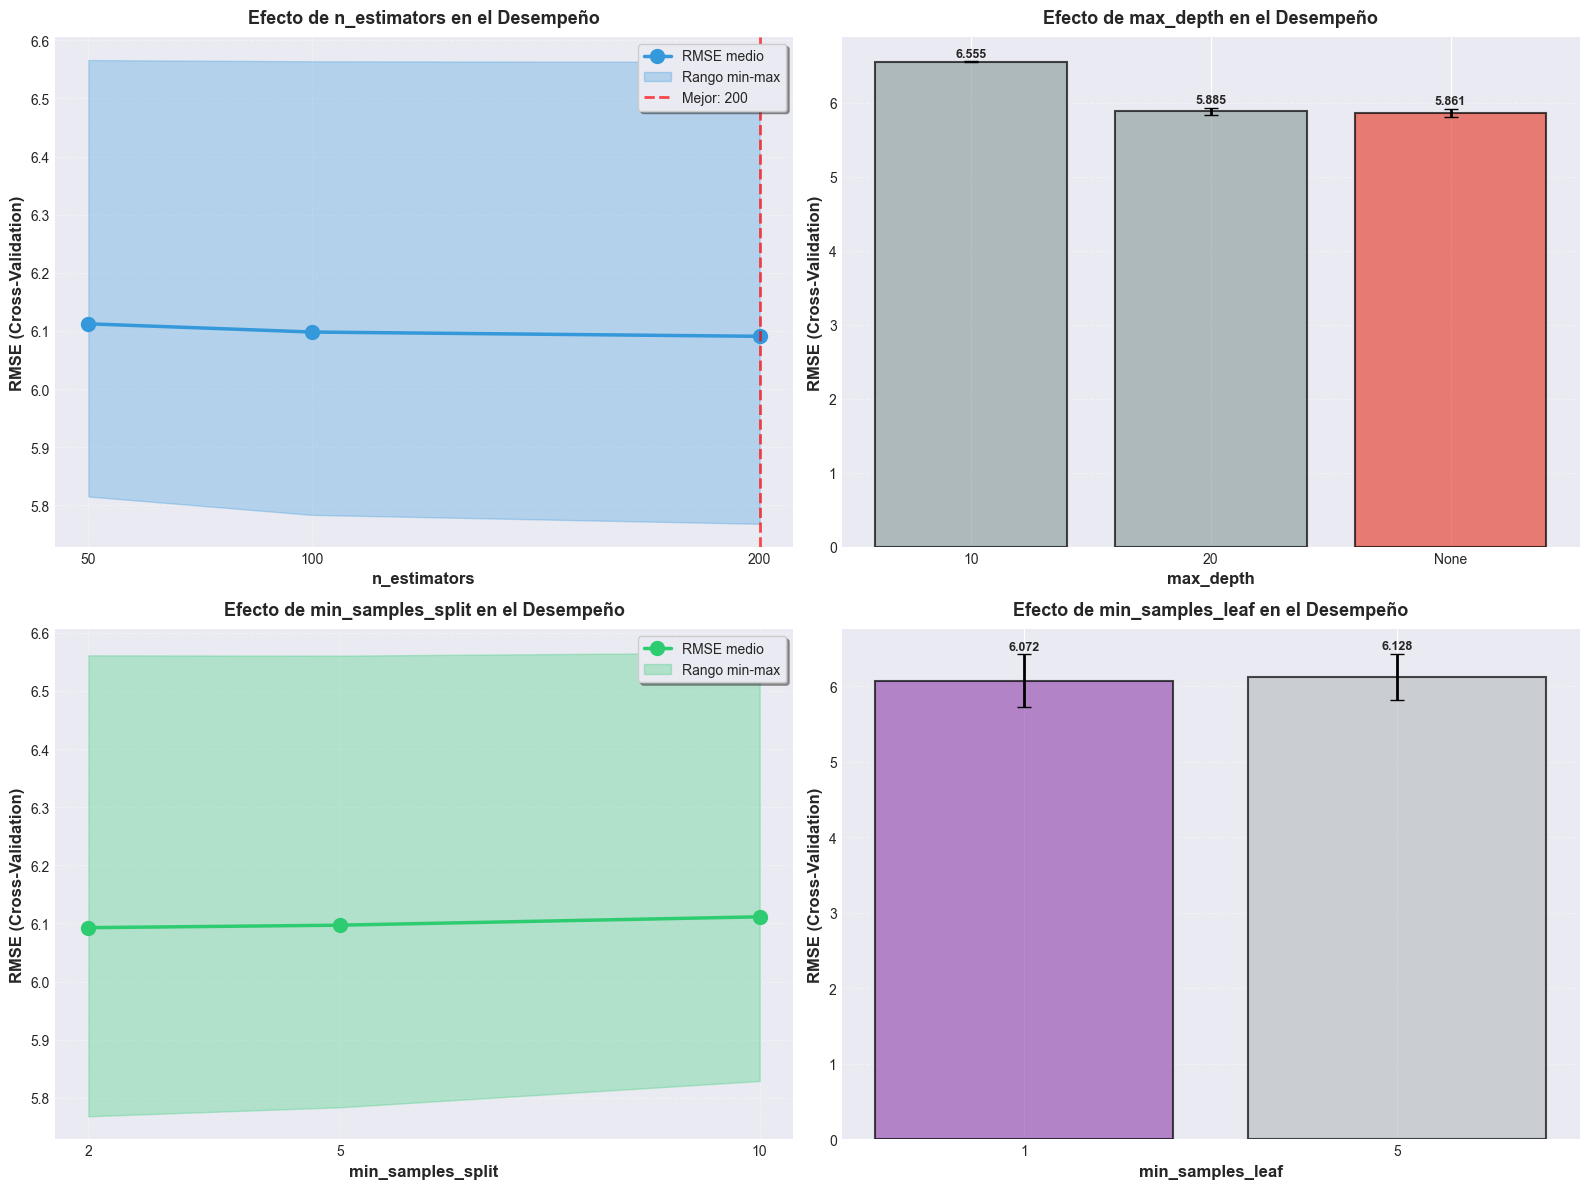


📊 RESUMEN DEL EFECTO DE HIPERPARÁMETROS

Mejor n_estimators: 200
Mejor max_depth: None
Mejor min_samples_split: 2
Mejor min_samples_leaf: 1

💡 Observaciones:
   - Aumentar n_estimators generalmente mejora el desempeño (hasta cierto punto)
   - max_depth=None (sin límite) funciona mejor para este problema
   - Valores bajos de min_samples_split y min_samples_leaf permiten mejor ajuste


In [46]:
### 12.5. Análisis del Efecto de Hiperparámetros

# Visualización del efecto de diferentes hiperparámetros
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Efecto de n_estimators
axes[0, 0].plot(efecto_n_estimators['n_estimators'], efecto_n_estimators['RMSE_mean'], 
                'o-', linewidth=2.5, markersize=10, color='#3498db', label='RMSE medio')
axes[0, 0].fill_between(efecto_n_estimators['n_estimators'], 
                        efecto_n_estimators['RMSE_min'], 
                        efecto_n_estimators['RMSE_max'], 
                        alpha=0.3, color='#3498db', label='Rango min-max')
axes[0, 0].set_xlabel('n_estimators', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('RMSE (Cross-Validation)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Efecto de n_estimators en el Desempeño', 
                     fontsize=13, fontweight='bold', pad=10)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')
axes[0, 0].legend(loc='upper right', frameon=True, shadow=True, fontsize=10)
axes[0, 0].set_xticks(efecto_n_estimators['n_estimators'])

# Marcar el mejor valor
mejor_n_est = efecto_n_estimators.loc[efecto_n_estimators['RMSE_mean'].idxmin(), 'n_estimators']
axes[0, 0].axvline(mejor_n_est, color='red', linestyle='--', linewidth=2, 
                   label=f'Mejor: {mejor_n_est}', alpha=0.7)
axes[0, 0].legend(loc='upper right', frameon=True, shadow=True, fontsize=10)

# 2. Efecto de max_depth
x_depth = np.arange(len(efecto_max_depth))
axes[0, 1].bar(x_depth, efecto_max_depth['RMSE_mean'], 
               color=['#e74c3c' if depth == 'None' else '#95a5a6' for depth in efecto_max_depth['max_depth']], 
               alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0, 1].errorbar(x_depth, efecto_max_depth['RMSE_mean'], 
                    yerr=efecto_max_depth['RMSE_std'], 
                    fmt='none', ecolor='black', capsize=5, linewidth=2)
axes[0, 1].set_xticks(x_depth)
axes[0, 1].set_xticklabels(efecto_max_depth['max_depth'])
axes[0, 1].set_xlabel('max_depth', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('RMSE (Cross-Validation)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Efecto de max_depth en el Desempeño', 
                     fontsize=13, fontweight='bold', pad=10)
axes[0, 1].grid(True, alpha=0.3, axis='y', linestyle='--')

# Agregar valores
for i, (idx, row) in enumerate(efecto_max_depth.iterrows()):
    axes[0, 1].text(i, row['RMSE_mean'] + row['RMSE_std'] + 0.02, 
                   f"{row['RMSE_mean']:.3f}", ha='center', va='bottom', 
                   fontsize=9, fontweight='bold')

# 3. Efecto de min_samples_split
axes[1, 0].plot(efecto_min_split['min_samples_split'], efecto_min_split['RMSE_mean'], 
                'o-', linewidth=2.5, markersize=10, color='#2ecc71', label='RMSE medio')
axes[1, 0].fill_between(efecto_min_split['min_samples_split'], 
                        efecto_min_split['RMSE_min'], 
                        efecto_min_split['RMSE_max'], 
                        alpha=0.3, color='#2ecc71', label='Rango min-max')
axes[1, 0].set_xlabel('min_samples_split', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('RMSE (Cross-Validation)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Efecto de min_samples_split en el Desempeño', 
                     fontsize=13, fontweight='bold', pad=10)
axes[1, 0].grid(True, alpha=0.3, linestyle='--')
axes[1, 0].legend(loc='upper right', frameon=True, shadow=True, fontsize=10)
axes[1, 0].set_xticks(efecto_min_split['min_samples_split'])

# 4. Efecto de min_samples_leaf
x_leaf = np.arange(len(efecto_min_leaf))
axes[1, 1].bar(x_leaf, efecto_min_leaf['RMSE_mean'], 
               color=['#9b59b6' if leaf == 1 else '#bdc3c7' for leaf in efecto_min_leaf['min_samples_leaf']], 
               alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 1].errorbar(x_leaf, efecto_min_leaf['RMSE_mean'], 
                    yerr=efecto_min_leaf['RMSE_std'], 
                    fmt='none', ecolor='black', capsize=5, linewidth=2)
axes[1, 1].set_xticks(x_leaf)
axes[1, 1].set_xticklabels(efecto_min_leaf['min_samples_leaf'])
axes[1, 1].set_xlabel('min_samples_leaf', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('RMSE (Cross-Validation)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Efecto de min_samples_leaf en el Desempeño', 
                     fontsize=13, fontweight='bold', pad=10)
axes[1, 1].grid(True, alpha=0.3, axis='y', linestyle='--')

# Agregar valores
for i, (idx, row) in enumerate(efecto_min_leaf.iterrows()):
    axes[1, 1].text(i, row['RMSE_mean'] + row['RMSE_std'] + 0.02, 
                   f"{row['RMSE_mean']:.3f}", ha='center', va='bottom', 
                   fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("📊 RESUMEN DEL EFECTO DE HIPERPARÁMETROS")
print("="*80)
print(f"\nMejor n_estimators: {efecto_n_estimators.loc[efecto_n_estimators['RMSE_mean'].idxmin(), 'n_estimators']}")
print(f"Mejor max_depth: {efecto_max_depth.loc[efecto_max_depth['RMSE_mean'].idxmin(), 'max_depth']}")
print(f"Mejor min_samples_split: {efecto_min_split.loc[efecto_min_split['RMSE_mean'].idxmin(), 'min_samples_split']}")
print(f"Mejor min_samples_leaf: {efecto_min_leaf.loc[efecto_min_leaf['RMSE_mean'].idxmin(), 'min_samples_leaf']}")
print("\n💡 Observaciones:")
print("   - Aumentar n_estimators generalmente mejora el desempeño (hasta cierto punto)")
print("   - max_depth=None (sin límite) funciona mejor para este problema")
print("   - Valores bajos de min_samples_split y min_samples_leaf permiten mejor ajuste")
print("="*80)


In [47]:
### 12.6. Resumen Final de Visualizaciones

print("\n" + "="*80)
print("📊 RESUMEN FINAL DE RESULTADOS")
print("="*80)

# Mejor modelo
mejor_idx = tabla_completa['RMSE_Val'].idxmin()
mejor = tabla_completa.loc[mejor_idx]

print(f"\n🏆 MEJOR MODELO:")
print(f"   Tipo: {mejor['Modelo']}")
print(f"   RMSE (Validation): {mejor['RMSE_Val']:.4f}")
print(f"   R² (Validation): {mejor['R²_Val']:.4f}")
print(f"   MAE (Validation): {mejor['MAE_Val']:.4f}")

print(f"\n📈 MÉTRICAS DE CROSS-VALIDATION (5-fold):")
print(f"   RMSE: {mejor['RMSE_CV_mean']:.4f} ± {mejor['RMSE_CV_std']:.4f}")
print(f"   R²: {mejor['R²_CV_mean']:.4f} ± {mejor['R²_CV_std']:.4f}")

print(f"\n🎯 CARACTERÍSTICAS MÁS IMPORTANTES:")
for i, (idx, row) in enumerate(importancias_mejor.head(5).iterrows(), 1):
    print(f"   {i}. {row['Característica']}: {row['Importancia']:.4f} ({row['Importancia']*100:.2f}%)")

print(f"\n📊 PREDICCIONES EN TEST:")
print(f"   Total de predicciones: {len(y_test_pred_mejor_clipped)}")
print(f"   Media: {y_test_pred_mejor_clipped.mean():.2f}")
print(f"   Rango: [{y_test_pred_mejor_clipped.min():.2f}, {y_test_pred_mejor_clipped.max():.2f}]")
print(f"   Desviación estándar: {y_test_pred_mejor_clipped.std():.2f}")

print(f"\n✅ ARCHIVO DE PREDICCIONES:")
print(f"   📁 {output_path}")
print(f"   🎯 Listo para subir a Kaggle")

print("\n" + "="*80)
print("🎉 ANÁLISIS COMPLETO FINALIZADO")
print("="*80)



📊 RESUMEN FINAL DE RESULTADOS

🏆 MEJOR MODELO:
   Tipo: RF_Optuna
   RMSE (Validation): 5.7012
   R² (Validation): 0.9343
   MAE (Validation): 3.0242

📈 MÉTRICAS DE CROSS-VALIDATION (5-fold):
   RMSE: 5.7564 ± 0.0649
   R²: 0.9337 ± 0.0012

🎯 CARACTERÍSTICAS MÁS IMPORTANTES:
   1. album_mean_popularity: 0.8859 (88.59%)
   2. genre_mean_popularity: 0.0384 (3.84%)
   3. artist_count: 0.0144 (1.44%)
   4. instrumentalness: 0.0085 (0.85%)
   5. loudness: 0.0080 (0.80%)

📊 PREDICCIONES EN TEST:
   Total de predicciones: 34200
   Media: 31.75
   Rango: [0.00, 94.75]
   Desviación estándar: 19.12

✅ ARCHIVO DE PREDICCIONES:
   📁 c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio\data\predictions_random_forest.csv
   🎯 Listo para subir a Kaggle

🎉 ANÁLISIS COMPLETO FINALIZADO


## 10. Conclusiones

### Resumen del Modelo de Random Forest Regressor

El modelo de Random Forest Regressor ha sido entrenado y evaluado con las siguientes características:

- **Características utilizadas**: Variables numéricas y características de feature engineering (artist_count, album_mean_popularity, genre_mean_popularity, etc.)
- **Escalado**: No requerido (Random Forest no necesita normalización)
- **Post-procesamiento**: Clipping aplicado al rango válido [0, 100] para mantener predicciones dentro del dominio de la variable objetivo
- **Métricas principales**: RMSE, MAE y R²
- **Hiperparámetros**: n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1
- **Ajuste de características**: `album_mean_popularity` transformada con `shrinkage_factor=0.6` para reducir su dominancia

### Ventajas de Random Forest Regressor:
- ✅ Puede capturar relaciones no lineales entre características y target
- ✅ Proporciona importancia de características (feature importances)
- ✅ Robusto a outliers y valores faltantes
- ✅ Menos propenso al sobreajuste que un árbol individual (gracias al ensemble)
- ✅ No requiere escalado de características
- ✅ Puede manejar interacciones entre características automáticamente
- ✅ El clipping asegura que las predicciones estén en el rango válido [0, 100]

### Limitaciones:
- ⚠️ Menos interpretable que modelos lineales (aunque tiene feature importances)
- ⚠️ Puede ser computacionalmente costoso con muchos árboles
- ⚠️ Puede sobreajustarse si no se ajustan bien los hiperparámetros
- ⚠️ Requiere más memoria que modelos lineales

### Comparación con Regresión Lineal:
Random Forest generalmente supera a la Regresión Lineal cuando hay relaciones no lineales complejas en los datos. Sin embargo, es importante comparar ambos modelos en el mismo conjunto de datos para determinar cuál funciona mejor para este problema específico.

### Próximos Pasos (Etapa 4):
- Realizar búsqueda sistemática de hiperparámetros con Grid Search o Random Search
- Usar validación cruzada (K-Fold) o Repeated Holdout para evaluación más robusta
- Comparar diferentes configuraciones del modelo
- Seleccionar el mejor modelo basado en métricas de validación